In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image

In [3]:
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"

In [4]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())

In [5]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'dt': 0.001, 'usteps': 1000, 'avail_seed': 8, 'temp_steps': 20, 'step_unit': 1000, 'equil_time': 40, 'run_time': 10, 'max_alpha_time': 1000, 'alpha_iters': 20, '_status': {}}

d395695118c2c7c531f3aeee70f4b196
{'N': 32768, 'replica': 0, 'rho': 1.2, 'pot': 'KA_WCA'}
37ae73cd14c8398e29fed6204f43a155
{'N': 32768, 'replica': 0, 'rho': 1.1, 'pot': 'KA_WCA'}


KeyboardInterrupt: 

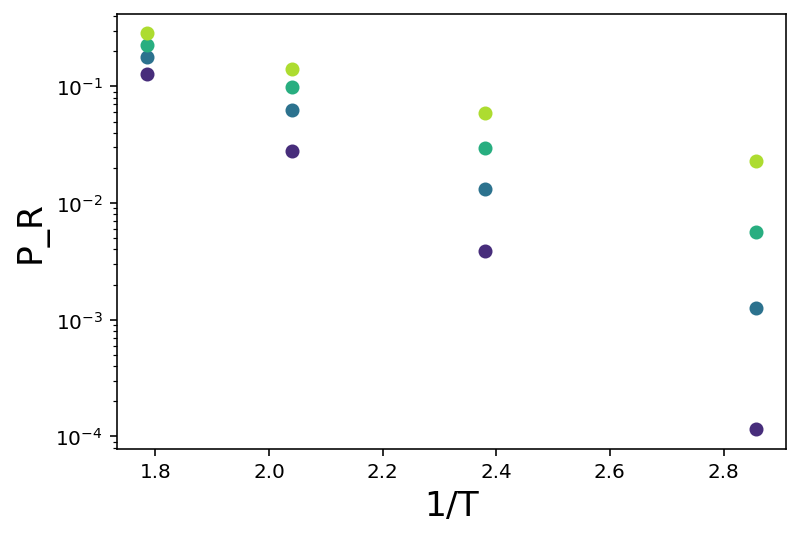

<Figure size 432x288 with 0 Axes>

In [6]:
for job in project.find_jobs(None, {"softness_trained": True}):
    dfs = sorted(glob.glob(job.fn("analysis/analysis-sfs_*.parquet")))
    print(job)
    print(job.sp)

    plt.figure()

    cats = None
    
    for idx, df_name in enumerate(dfs):
        df = pd.read_parquet(df_name)
        df = df[df["type"] == 0]
        temp = float(utils.extract_between(df_name, "analysis-sfs_temp-", ".parquet"))
        
        if cats is None:
            df["cut"], cats = pd.cut(df["softness"], 4, retbins=True)
            cmap = cm.viridis
            norm = colors.Normalize(vmin=cats.min(), vmax=cats.max())
        else:
            df["cut"] = pd.cut(df["softness"], cats)
        
        gdf = df.groupby("cut")
        for soft, df in gdf:
            rearrang = df["phop"] > 0.2
            if rearrang.mean() == 0.0:
                print(df["phop"].describe())
            plt.plot(1/temp, rearrang.mean(), "o", color=cmap(norm(soft.mid)))

    # break

    plt.yscale('log')
    plt.xlabel("1/T")
    plt.ylabel("P_R")

In [8]:
r_be = np.linspace(0.1, 5.0, 246)
r_bc = r_be[:-1] + np.diff(r_be)/2

def digitize_mask(x, mu_min, mu_max, bins):
    digs = np.floor((x - mu_min) / (mu_max - mu_min) * bins).astype(np.int32)
    return np.ma.masked_array(digs, mask=(digs < 0) | (digs >= bins))

def digitize_in_bounds(x, mu_min, mu_max, bins):
    digs = digitize_mask(x, mu_min, mu_max, bins)
    return digs[~digs.mask].data

def bin_linspaced_data(x, mu_min, mu_max, bins):
    digs = digitize_in_bounds(x, mu_min, mu_max, bins)
    return np.bincount(digs, minlength=bins)

def pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi):
    dr = r[1] - r[0]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return -2.0*np.pi*phi*f_a*np.sum(np.nan_to_num(g_a*np.log(g_a) - g_a + 1)*r*r)*dr \
                + -2.0*np.pi*phi*f_b*np.sum(np.nan_to_num(g_b*np.log(g_b) - g_b + 1)*r*r)*dr

d395695118c2c7c531f3aeee70f4b196
{'N': 32768, 'replica': 0, 'rho': 1.2, 'pot': 'KA_WCA'}
[-0.58822065 -0.73217362  0.04693435 ... -0.09263602  0.43462255
 -0.85301852]
[-0.96155562  0.64316281]
[-0.96155562 -0.64061193 -0.31966825  0.00127544  0.32221912  0.64316281]
848bac84d23c56bb5e7cbef2d87d5b61
{'N': 32768, 'replica': 0, 'rho': 1.4, 'pot': 'KA_LJ'}
[-0.11489641 -0.07105446 -0.15837931 ...  0.17027021  0.22753837
 -0.15849845]
[-0.92566967  0.5013784 ]
[-0.92566967 -0.64026006 -0.35485044 -0.06944083  0.21596879  0.5013784 ]
2235dfb89ffc998c28e26ddb0aa5889f
{'N': 32768, 'replica': 0, 'rho': 1.6, 'pot': 'KA_WCA'}
[-0.57921408 -0.04401196 -1.10057811 ... -0.62114261  0.23783283
  0.03251393]
[-0.97093399  0.56082511]
[-0.97093399 -0.66458217 -0.35823035 -0.05187853  0.25447329  0.56082511]
6f9e365130a0f6be570fcc9758c9875d
{'N': 32768, 'replica': 0, 'rho': 1.6, 'pot': 'KA_LJ'}
[-0.92883839 -0.81845048  0.19758372 ... -0.30896447 -0.00913413
 -0.38014115]
[-0.77410962  0.52656841]
[-0.

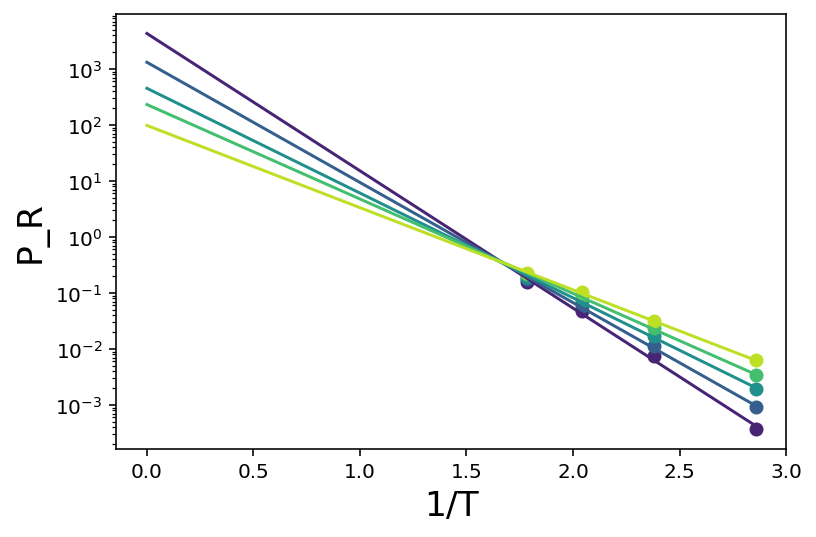

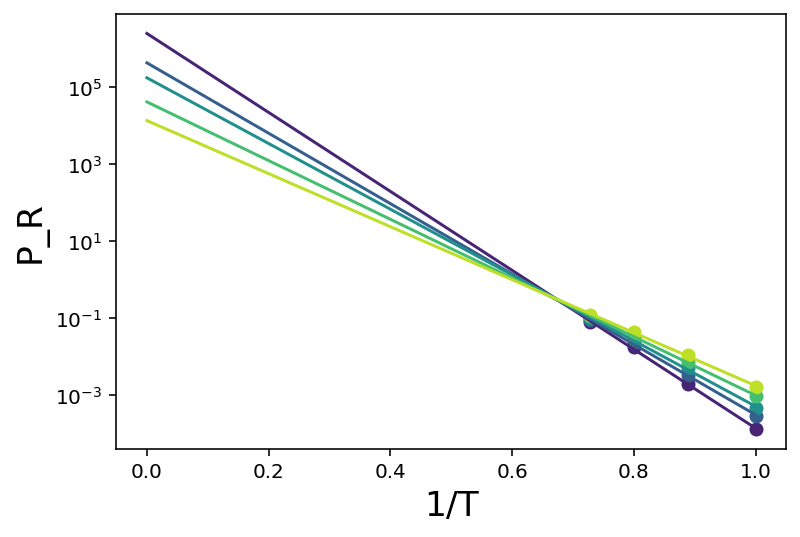

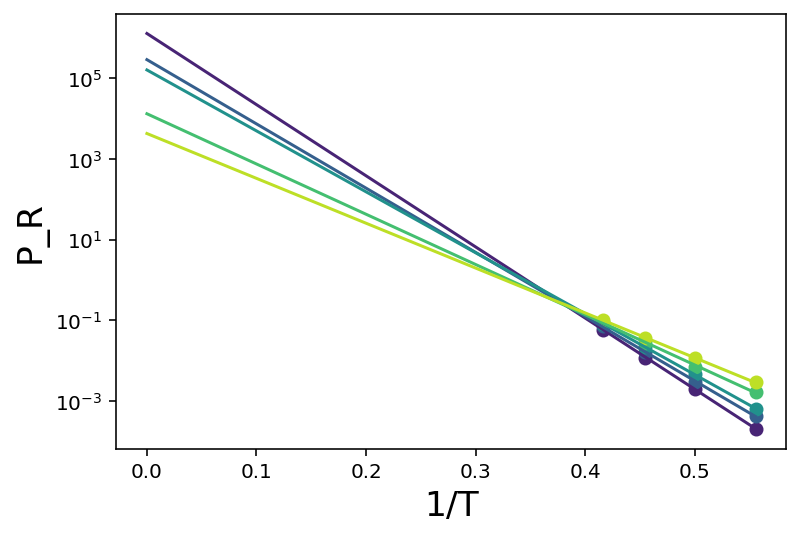

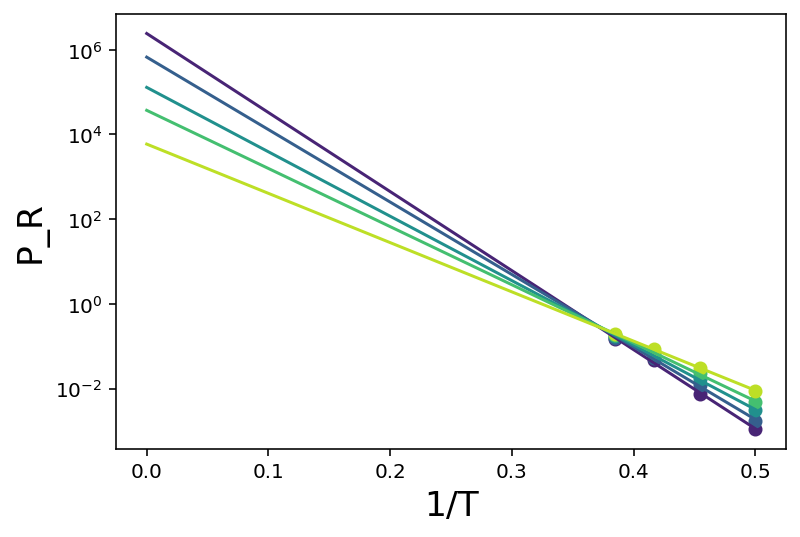

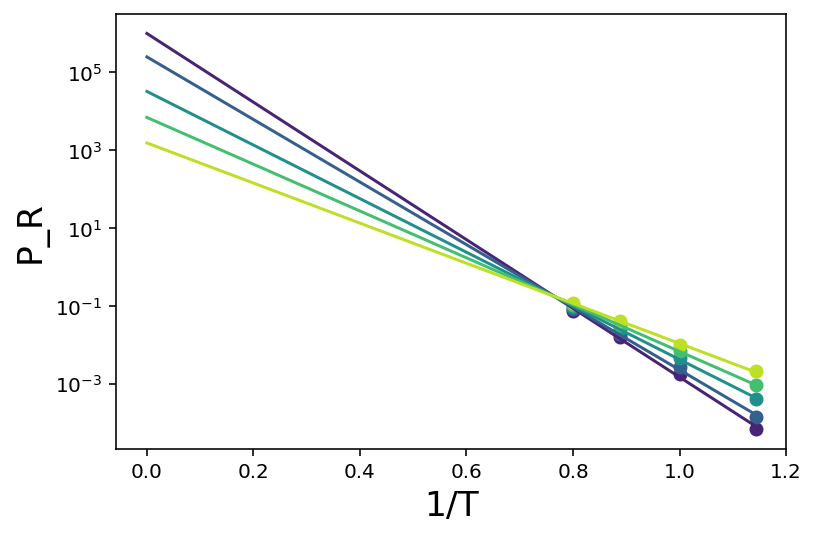

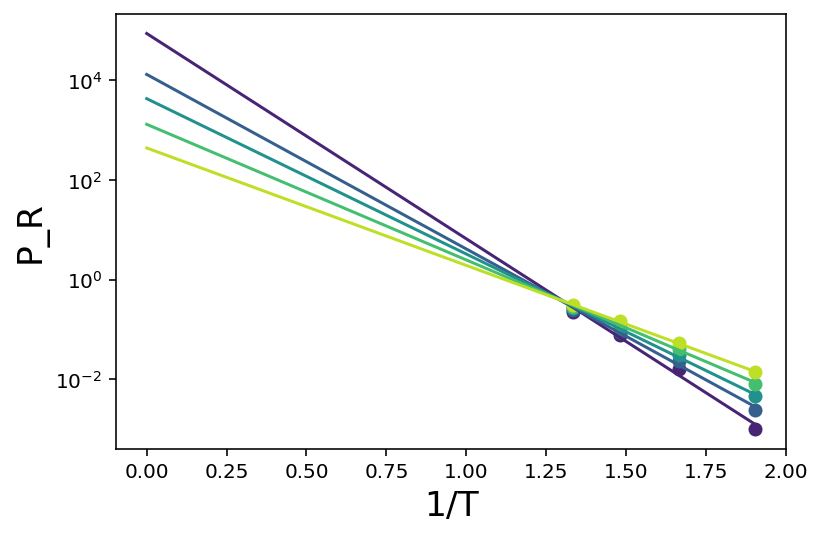

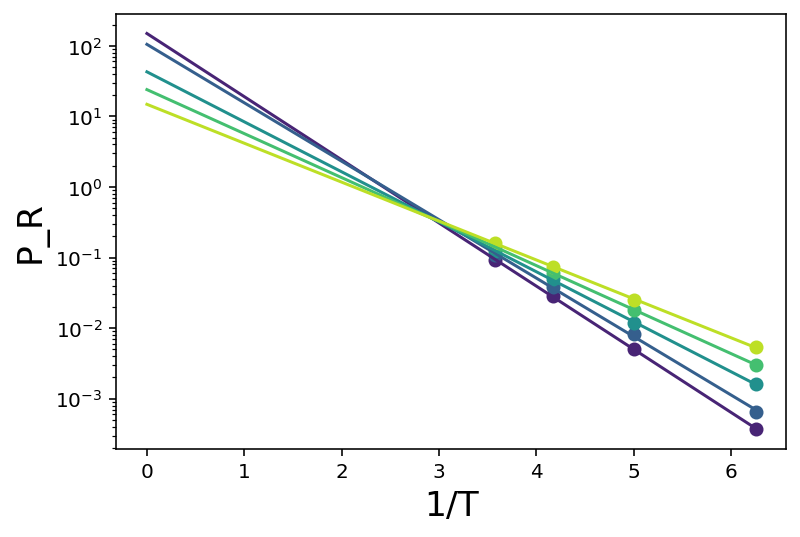

In [45]:


def _default_array():
    return np.zeros_like(r_bc)

for job in project.find_jobs(None, {"softness_trained": True}):
    dfs = sorted(glob.glob(job.fn("analysis/analysis-sfs_*.parquet")))
    print(job)
    print(job.sp)

    cats = None

    plt.figure()

    temps = []
    rearrang_data = []
    data = defaultdict(list)
    
    for idx, df_name in enumerate(dfs):
        df = pd.read_parquet(df_name)
        df.dropna(inplace=True)
        temp = float(utils.extract_between(df_name, "analysis-sfs_temp-", ".parquet"))
        traj = gsd.hoomd.open(job.fn(f"analysis/fire_temp-{temp:.3f}.gsd"))
        
        if cats is None:
            soft = df["softness"].to_numpy()
            print(soft)
            quants = np.quantile(soft, np.array([0.05, 0.95]))
            print(quants)
            cats = np.linspace(quants[0], quants[1], 6)
            print(cats)
            df["cut"] = pd.cut(df["softness"], cats)
            cmap = cm.viridis
            norm = colors.Normalize(vmin=cats.min(), vmax=cats.max())
            be = cats
            soft_bin_centers = be[:-1] + np.diff(be)/2
        else:
            df["cut"] = pd.cut(df["softness"], cats)

        temps.append(1/temp)

        cuts = []
        rate = []
        
        gdf = df.groupby("cut")
        for soft, tdf in gdf:
            rearrang = tdf["phop"] > 0.2
            cuts.append(soft.mid)
            rate.append(rearrang.mean())
            if rearrang.mean() != 0.0:
                data[soft.mid].append(rearrang.mean())
                plt.plot(1/temp, rearrang.mean(), "o", color=cmap(norm(soft.mid)))
            else:
                data[soft.mid].append(np.nan)

        rdf_a = defaultdict(_default_array)
        rdf_b = defaultdict(_default_array)

        vol = 4/3*np.pi*r_be[-1]**3
        shells = 4*np.pi*r_bc**2*(r_be[1] - r_be[0])

        for frame, tdf in df.groupby("frame"):
            snap: gsd.hoomd.Snapshot = traj[int(frame)]
            box = freud.box.Box.from_box(snap.configuration.box)
            pos = snap.particles.position
            pos_a = pos[snap.particles.typeid == 0]
            pos_b = pos[snap.particles.typeid == 1]
            nlist_query_a = freud.locality.AABBQuery.from_system((box, pos_a))
            nlist_query_b = freud.locality.AABBQuery.from_system((box, pos_b))
            
            for soft, ttdf in tdf.groupby("cut"):
                id = ttdf["tag"].to_numpy()
                nlist_a = nlist_query_a.query(pos[id], dict(r_max=5.0, r_min=0.1)).toNeighborList()
                nlist_b = nlist_query_b.query(pos[id], dict(r_max=5.0, r_min=0.1)).toNeighborList()
                rdf_a[float(soft.mid)] += bin_linspaced_data(nlist_a.distances, r_be[0], r_be[-1], len(r_be)-1)
                rdf_b[float(soft.mid)] += bin_linspaced_data(nlist_b.distances, r_be[0], r_be[-1], len(r_be)-1)
            del snap

        final_data = {}
        final_data["rdfs"] = {}
        
        for c in cuts:
            rdf = rdf_a[c]
            g_a = rdf/shells/np.sum(rdf)*vol
            rdf = rdf_b[c]
            g_b = rdf/shells/np.sum(rdf)*vol
            final_data["rdfs"][c] = dict(g_a=g_a, g_b=g_b)

        final_data["cuts"] = cuts
        final_data["rearrang"] = rate

        rearrang_data.append(final_data)

    barriers = {}

    for key, val in data.items():
        
        itemps = np.array(temps)
        val = np.array(val)
        mask = ~np.isnan(val)
        itemps = itemps[mask]
        val = val[mask]
        p = np.polyfit(itemps, np.log(val), 1)
        x = np.linspace(0.0, np.max(temps), 100)
        y = np.polyval(p, x)
        plt.plot(x, np.exp(y), color=cmap(norm(key)))

        barriers[key] = {"E": -p[0], "S": p[1]}

    barrier_out_file = job.fn("analysis/barriers.pickle")
    with open(barrier_out_file, "wb") as f:
        pickle.dump(barriers, f)

    rearrang_file = job.fn(f"analysis/rdfs-bin-softness-fire.pickle")
    pickle_data = dict(inv_t=temps, barriers=barriers, data=rearrang_data, r_bc=r_bc, r_be=r_be, cuts=soft_bin_centers)
    pickle.dump(pickle_data, open(rearrang_file, "wb"))

    plt.yscale('log')
    plt.xlabel("1/T")
    plt.ylabel("P_R")

d395695118c2c7c531f3aeee70f4b196
{'N': 32768, 'replica': 0, 'rho': 1.2, 'pot': 'KA_WCA'}
[-0.58822065 -0.73217362  0.04693435 ... -0.09263602  0.43462255
 -0.85301852]
[-0.96155562  0.64316281]
[-0.96155562 -0.64061193 -0.31966825  0.00127544  0.32221912  0.64316281]
848bac84d23c56bb5e7cbef2d87d5b61
{'N': 32768, 'replica': 0, 'rho': 1.4, 'pot': 'KA_LJ'}
[-0.11489641 -0.07105446 -0.15837931 ...  0.17027021  0.22753837
 -0.15849845]
[-0.92566967  0.5013784 ]
[-0.92566967 -0.64026006 -0.35485044 -0.06944083  0.21596879  0.5013784 ]
2235dfb89ffc998c28e26ddb0aa5889f
{'N': 32768, 'replica': 0, 'rho': 1.6, 'pot': 'KA_WCA'}
[-0.57921408 -0.04401196 -1.10057811 ... -0.62114261  0.23783283
  0.03251393]
[-0.97093399  0.56082511]
[-0.97093399 -0.66458217 -0.35823035 -0.05187853  0.25447329  0.56082511]
6f9e365130a0f6be570fcc9758c9875d
{'N': 32768, 'replica': 0, 'rho': 1.6, 'pot': 'KA_LJ'}
[-0.92883839 -0.81845048  0.19758372 ... -0.30896447 -0.00913413
 -0.38014115]
[-0.77410962  0.52656841]
[-0.

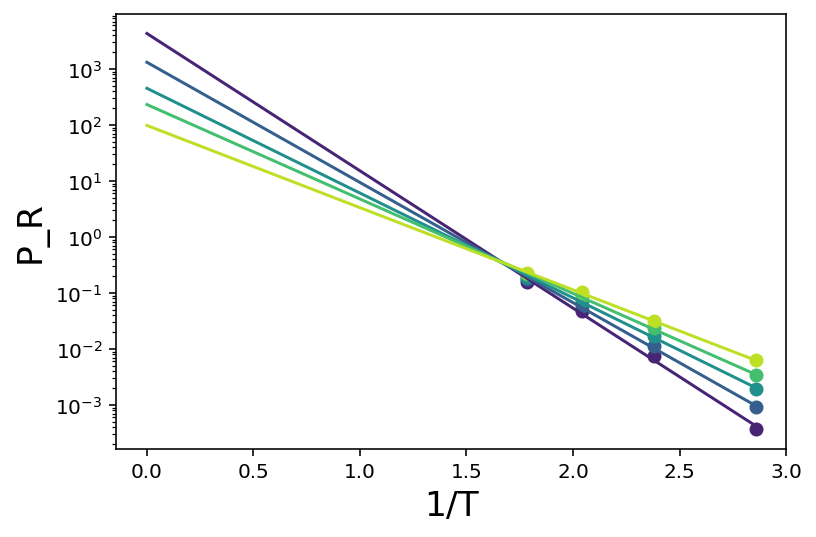

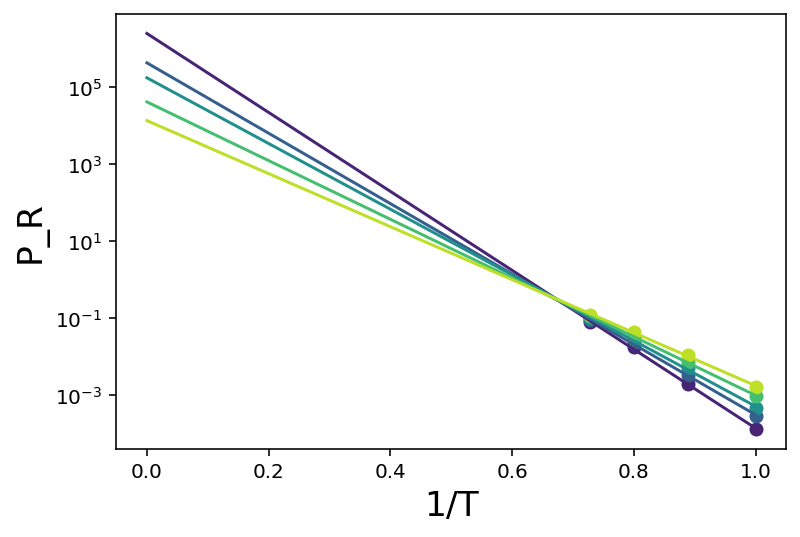

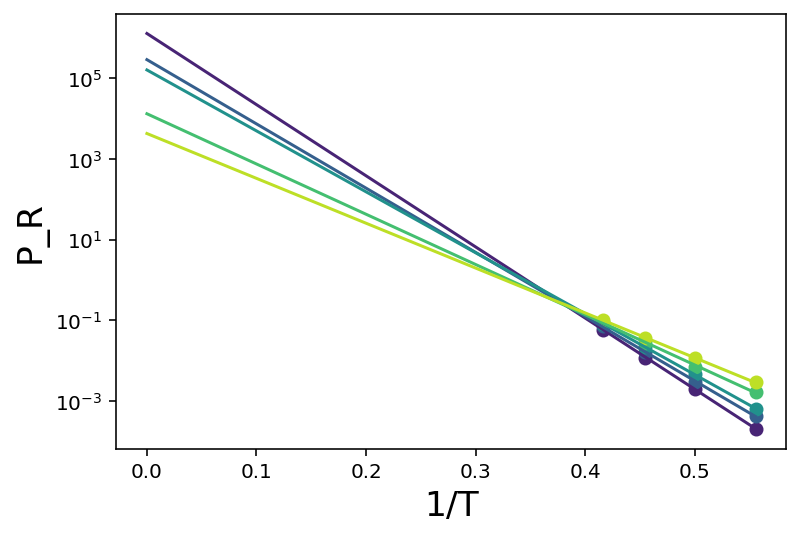

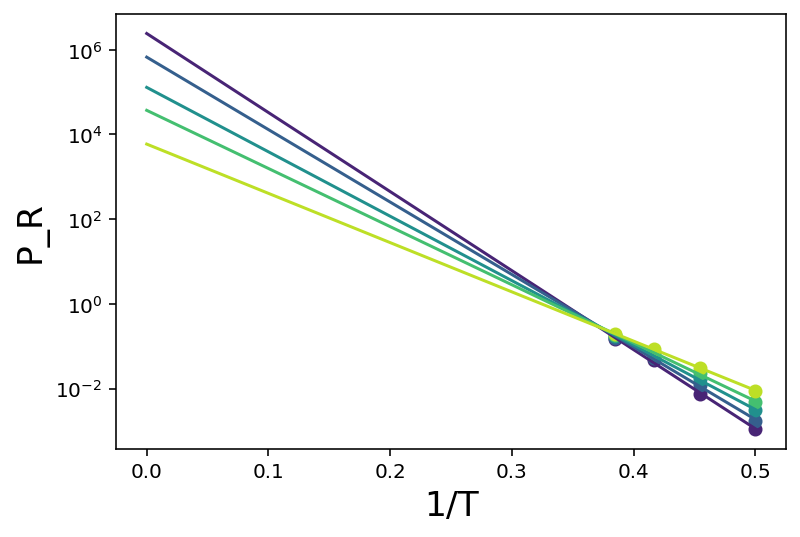

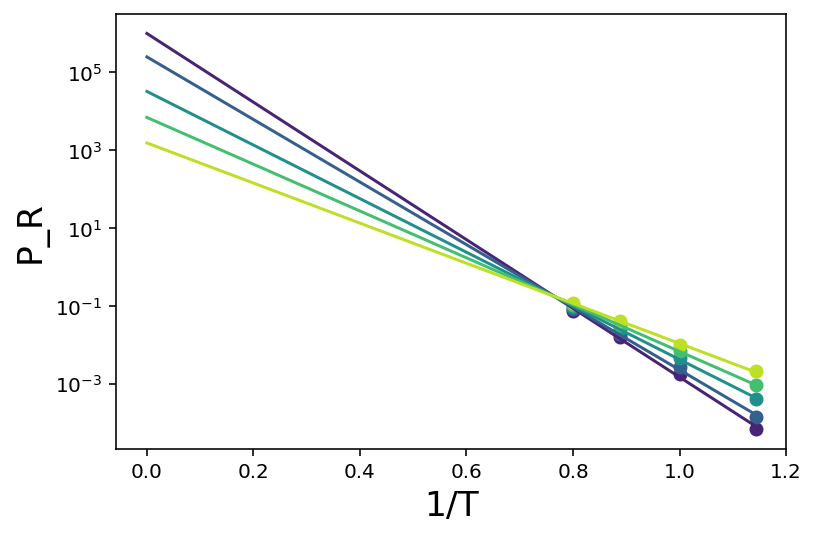

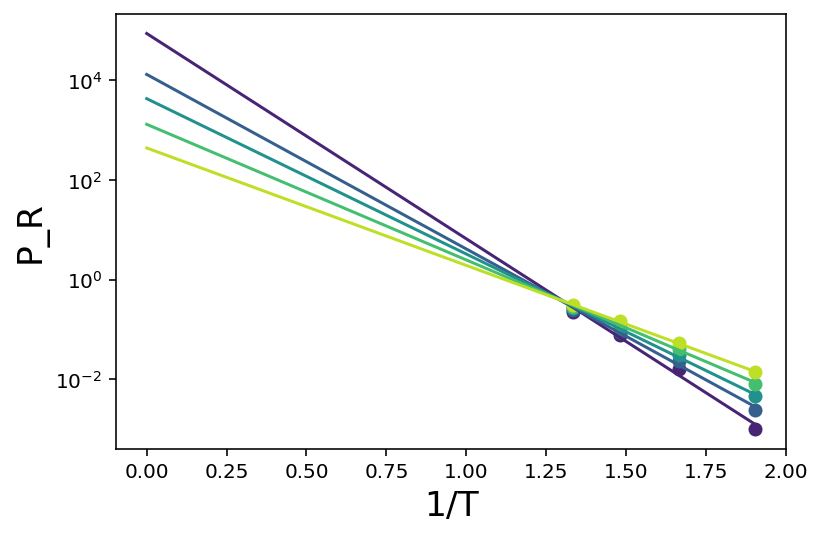

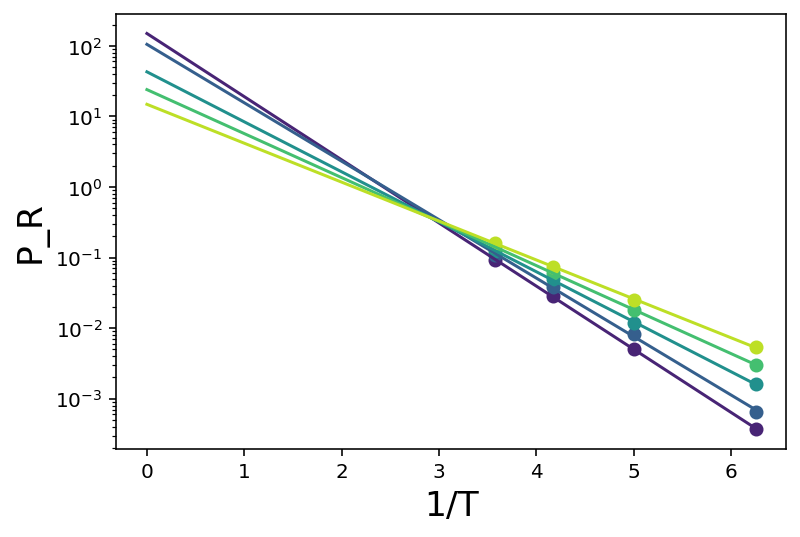

In [49]:

for job in project.find_jobs(None, {"softness_trained": True}):
    dfs = sorted(glob.glob(job.fn("analysis/analysis-sfs_*.parquet")))
    print(job)
    print(job.sp)

    cats = None

    plt.figure()

    temps = []
    rearrang_data = []
    data = defaultdict(list)
    
    for idx, df_name in enumerate(dfs):
        df = pd.read_parquet(df_name)
        df.dropna(inplace=True)
        temp = float(utils.extract_between(df_name, "analysis-sfs_temp-", ".parquet"))
        traj = gsd.hoomd.open(job.fn(f"equil/equil_temp-{temp:.3f}.gsd"))
        
        if cats is None:
            soft = df["softness"].to_numpy()
            print(soft)
            quants = np.quantile(soft, np.array([0.05, 0.95]))
            print(quants)
            cats = np.linspace(quants[0], quants[1], 6)
            print(cats)
            df["cut"] = pd.cut(df["softness"], cats)
            cmap = cm.viridis
            norm = colors.Normalize(vmin=cats.min(), vmax=cats.max())
            be = cats
            soft_bin_centers = be[:-1] + np.diff(be)/2
        else:
            df["cut"] = pd.cut(df["softness"], cats)

        temps.append(1/temp)

        cuts = []
        rate = []
        
        gdf = df.groupby("cut")
        for soft, tdf in gdf:
            rearrang = tdf["phop"] > 0.2
            cuts.append(soft.mid)
            rate.append(rearrang.mean())
            if rearrang.mean() != 0.0:
                data[soft.mid].append(rearrang.mean())
                plt.plot(1/temp, rearrang.mean(), "o", color=cmap(norm(soft.mid)))
            else:
                data[soft.mid].append(np.nan)

        rdf_a = defaultdict(_default_array)
        rdf_b = defaultdict(_default_array)

        vol = 4/3*np.pi*r_be[-1]**3
        shells = 4*np.pi*r_bc**2*(r_be[1] - r_be[0])

        for frame, tdf in df.groupby("frame"):
            snap: gsd.hoomd.Snapshot = traj[int(frame)]
            box = freud.box.Box.from_box(snap.configuration.box)
            pos = snap.particles.position
            pos_a = pos[snap.particles.typeid == 0]
            pos_b = pos[snap.particles.typeid == 1]
            nlist_query_a = freud.locality.AABBQuery.from_system((box, pos_a))
            nlist_query_b = freud.locality.AABBQuery.from_system((box, pos_b))
            
            for soft, ttdf in tdf.groupby("cut"):
                id = ttdf["tag"].to_numpy()
                nlist_a = nlist_query_a.query(pos[id], dict(r_max=5.0, r_min=0.1)).toNeighborList()
                nlist_b = nlist_query_b.query(pos[id], dict(r_max=5.0, r_min=0.1)).toNeighborList()
                rdf_a[float(soft.mid)] += bin_linspaced_data(nlist_a.distances, r_be[0], r_be[-1], len(r_be)-1)
                rdf_b[float(soft.mid)] += bin_linspaced_data(nlist_b.distances, r_be[0], r_be[-1], len(r_be)-1)
            del snap

        final_data = {}
        final_data["rdfs"] = {}
        
        for c in cuts:
            rdf = rdf_a[c]
            g_a = rdf/shells/np.sum(rdf)*vol
            rdf = rdf_b[c]
            g_b = rdf/shells/np.sum(rdf)*vol
            final_data["rdfs"][c] = dict(g_a=g_a, g_b=g_b)

        final_data["cuts"] = cuts
        final_data["rearrang"] = rate

        rearrang_data.append(final_data)

    barriers = {}

    for key, val in data.items():
        
        itemps = np.array(temps)
        val = np.array(val)
        mask = ~np.isnan(val)
        itemps = itemps[mask]
        val = val[mask]
        p = np.polyfit(itemps, np.log(val), 1)
        x = np.linspace(0.0, np.max(temps), 100)
        y = np.polyval(p, x)
        plt.plot(x, np.exp(y), color=cmap(norm(key)))

        barriers[key] = {"E": -p[0], "S": p[1]}

    # barrier_out_file = job.fn("analysis/barriers.pickle")
    # with open(barrier_out_file, "wb") as f:
    #     pickle.dump(barriers, f)

    rearrang_file = job.fn(f"analysis/rdfs-bin-softness.pickle")
    pickle_data = dict(inv_t=temps, barriers=barriers, data=rearrang_data, r_bc=r_bc, r_be=r_be, cuts=soft_bin_centers)
    pickle.dump(pickle_data, open(rearrang_file, "wb"))

    plt.yscale('log')
    plt.xlabel("1/T")
    plt.ylabel("P_R")

Text(0, 0.5, '$\\Sigma$')

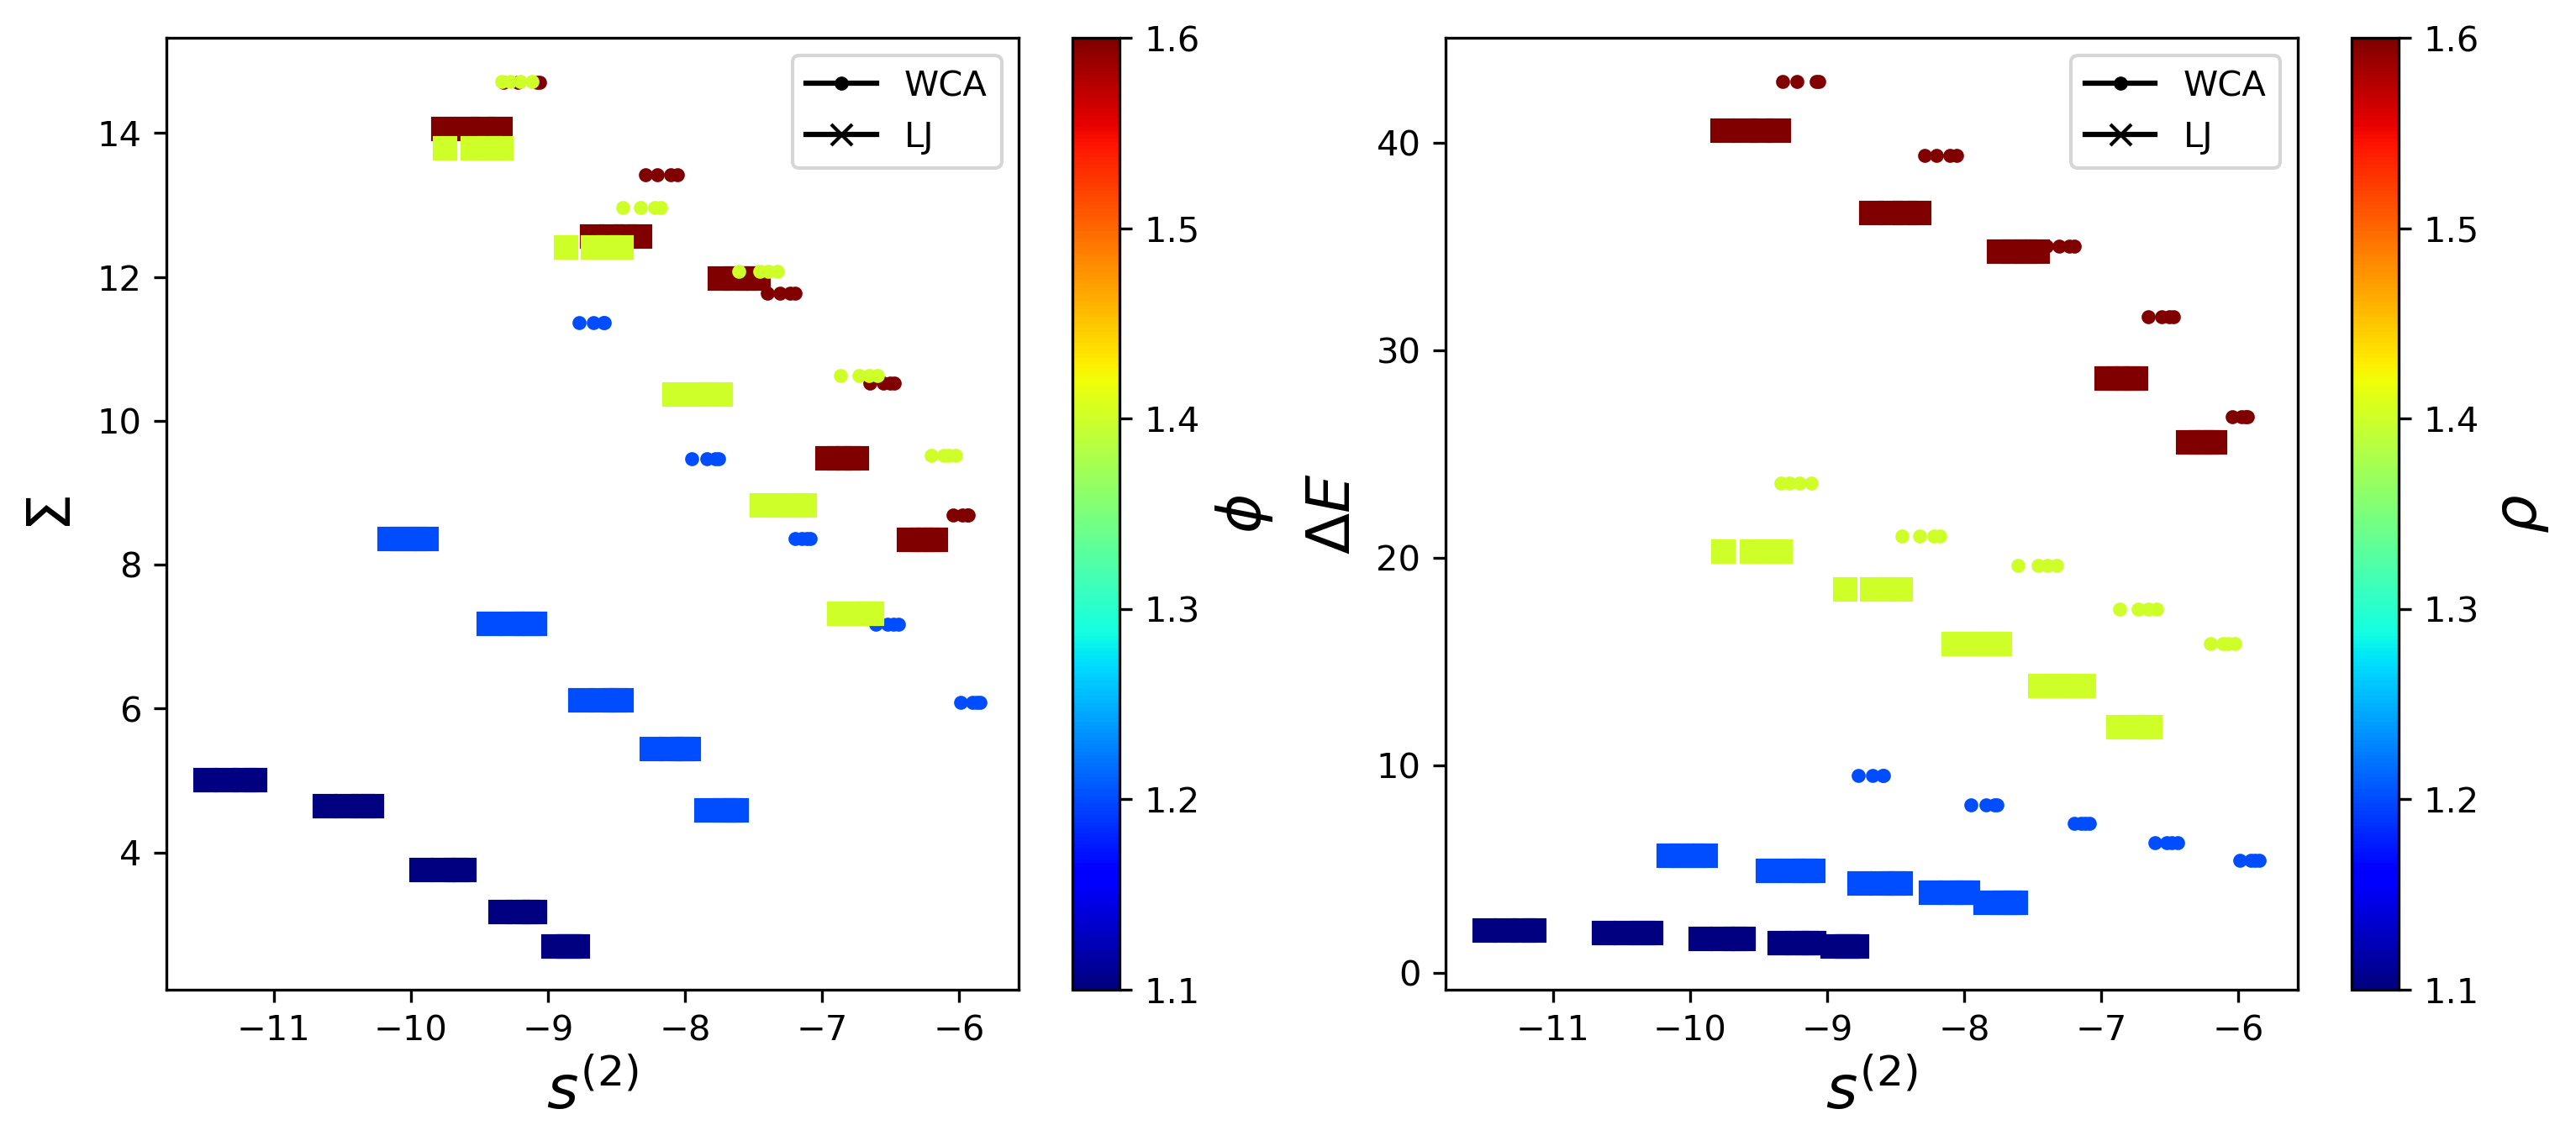

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

markers = {"KA_WCA": "s", "KA_LJ": "."}
cmap = cm.jet
norm = colors.Normalize(1.1, 1.6)

for job in project:
    if not job.isfile(f"analysis/rdfs-bin-softness-fire.pickle"):
        continue
    file = job.fn(f"analysis/rdfs-bin-softness-fire.pickle")

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = job.sp["rho"]
    for j in range(len(itemps)):
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            tmp_temps = np.array(itemps)
            tmp_val = np.array(rearrang)
            mask = ~np.isnan(tmp_val)
            tmp_temps = tmp_temps[mask]
            tmp_val = tmp_val[mask]
            p = np.polyfit(tmp_temps, np.log(tmp_val), 1)

            fits.append(p)

        # soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

        # def reject_outliers(sr, iq_range=0.8):
        #     pcnt = (1 - iq_range) / 2
        #     qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        #     iqr = qhigh - qlow
        #     return sr[ (sr - median).abs() <= iqr]

        # data1 = []
        # keys = list(soft["data"].keys())
        # for i in range(len(keys)-1):
        #     v1 = soft["data"][keys[i]]["p"]
        #     for j in range(i+1, len(keys)):
        #         v2 = soft["data"][keys[j]]["p"]
        #         data1.append((v2[1] - v1[1]) / (v1[0] - v2[0]))
        # T_a = np.mean(reject_outliers(pd.Series(data1)).to_numpy())

        fits = np.array(fits)

        axs[0].plot(np.array(entropy), fits[:,1], markers[job.sp["pot"]], linestyle="", color=cmap(norm(phi)))
        axs[1].plot(np.array(entropy), -fits[:,0], markers[job.sp["pot"]], linestyle="", color=cmap(norm(phi)))

axs[0].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[1].set_ylabel(r"$\Delta E$", size="xx-large")

plt.sca(axs[0])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\phi$")
custom_lines = [plt.Line2D([0], [0], color="k", marker=".", linestyle=None),
                plt.Line2D([0], [0], color="k", marker="x", linestyle=None)]
plt.legend(custom_lines, ["WCA", "LJ"])

plt.sca(axs[1])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\rho$")
plt.legend(custom_lines, ["WCA", "LJ"])

axs[1].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[0].set_ylabel(r"$\Sigma$", size="xx-large")

Text(0, 0.5, '$\\Sigma$')

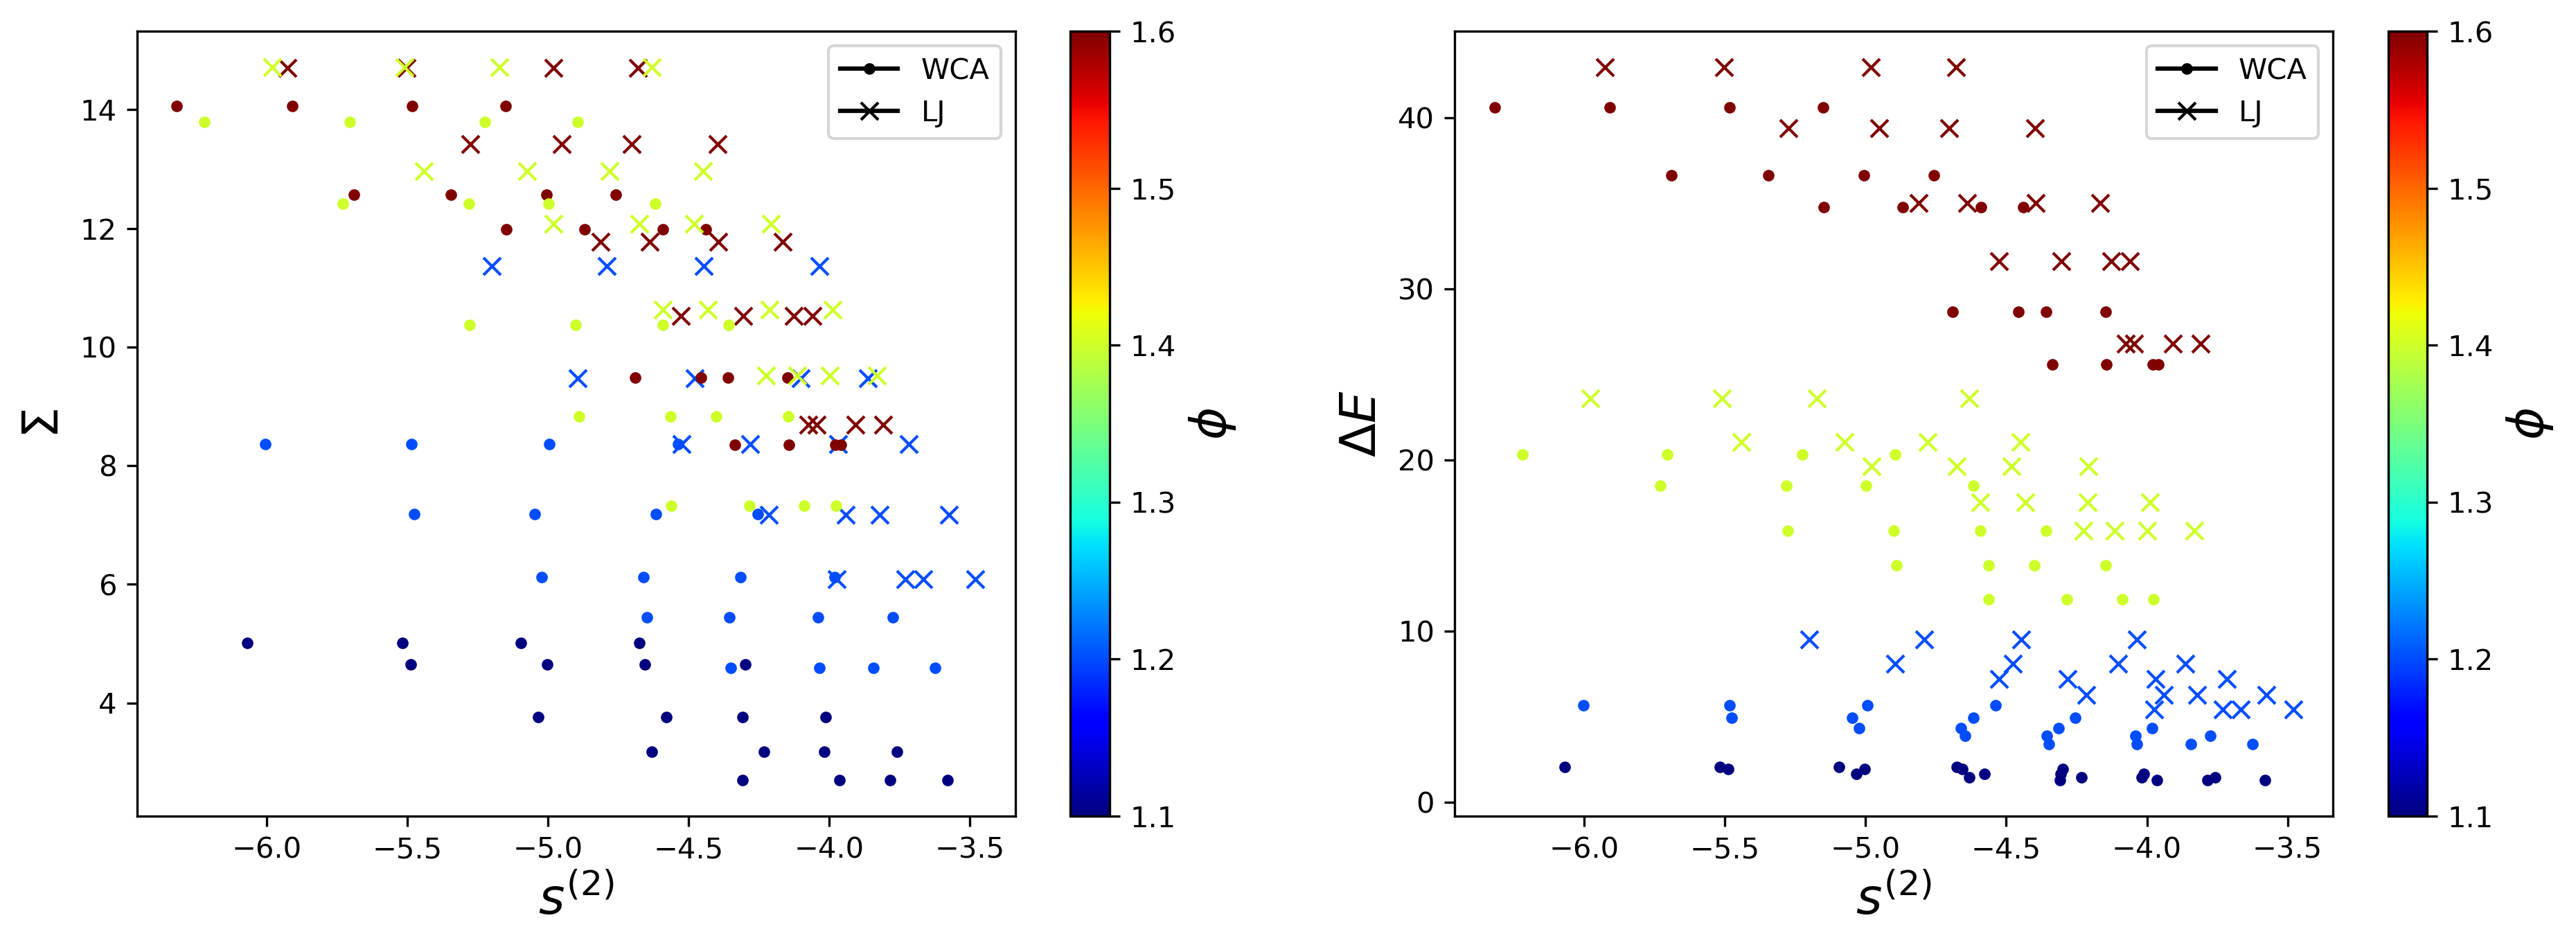

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

markers = {"KA_WCA": "s", "KA_LJ": "."}
cmap = cm.jet
norm = colors.Normalize(1.1, 1.6)

for job in project:
    if not job.isfile(f"analysis/rdfs-bin-softness.pickle"):
        continue
    file = job.fn(f"analysis/rdfs-bin-softness.pickle")

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = job.sp["rho"]
    for j in range(len(itemps)):
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            tmp_temps = np.array(itemps)
            tmp_val = np.array(rearrang)
            mask = ~np.isnan(tmp_val)
            tmp_temps = tmp_temps[mask]
            tmp_val = tmp_val[mask]
            p = np.polyfit(tmp_temps, np.log(tmp_val), 1)

            fits.append(p)

        fits = np.array(fits)

        axs[0].plot(np.array(entropy), fits[:,1], markers[job.sp["pot"]], linestyle="", color=cmap(norm(phi)))
        axs[1].plot(np.array(entropy), -fits[:,0], markers[job.sp["pot"]], linestyle="", color=cmap(norm(phi)))

axs[0].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[1].set_ylabel(r"$\Delta E$", size="xx-large")

plt.sca(axs[0])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\phi$")
custom_lines = [plt.Line2D([0], [0], color="k", marker=".", linestyle=None),
                plt.Line2D([0], [0], color="k", marker="x", linestyle=None)]
plt.legend(custom_lines, ["WCA", "LJ"])

plt.sca(axs[1])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\phi$")
plt.legend(custom_lines, ["WCA", "LJ"])

axs[1].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[0].set_ylabel(r"$\Sigma$", size="xx-large")

Text(0, 0.5, '$\\Sigma$')

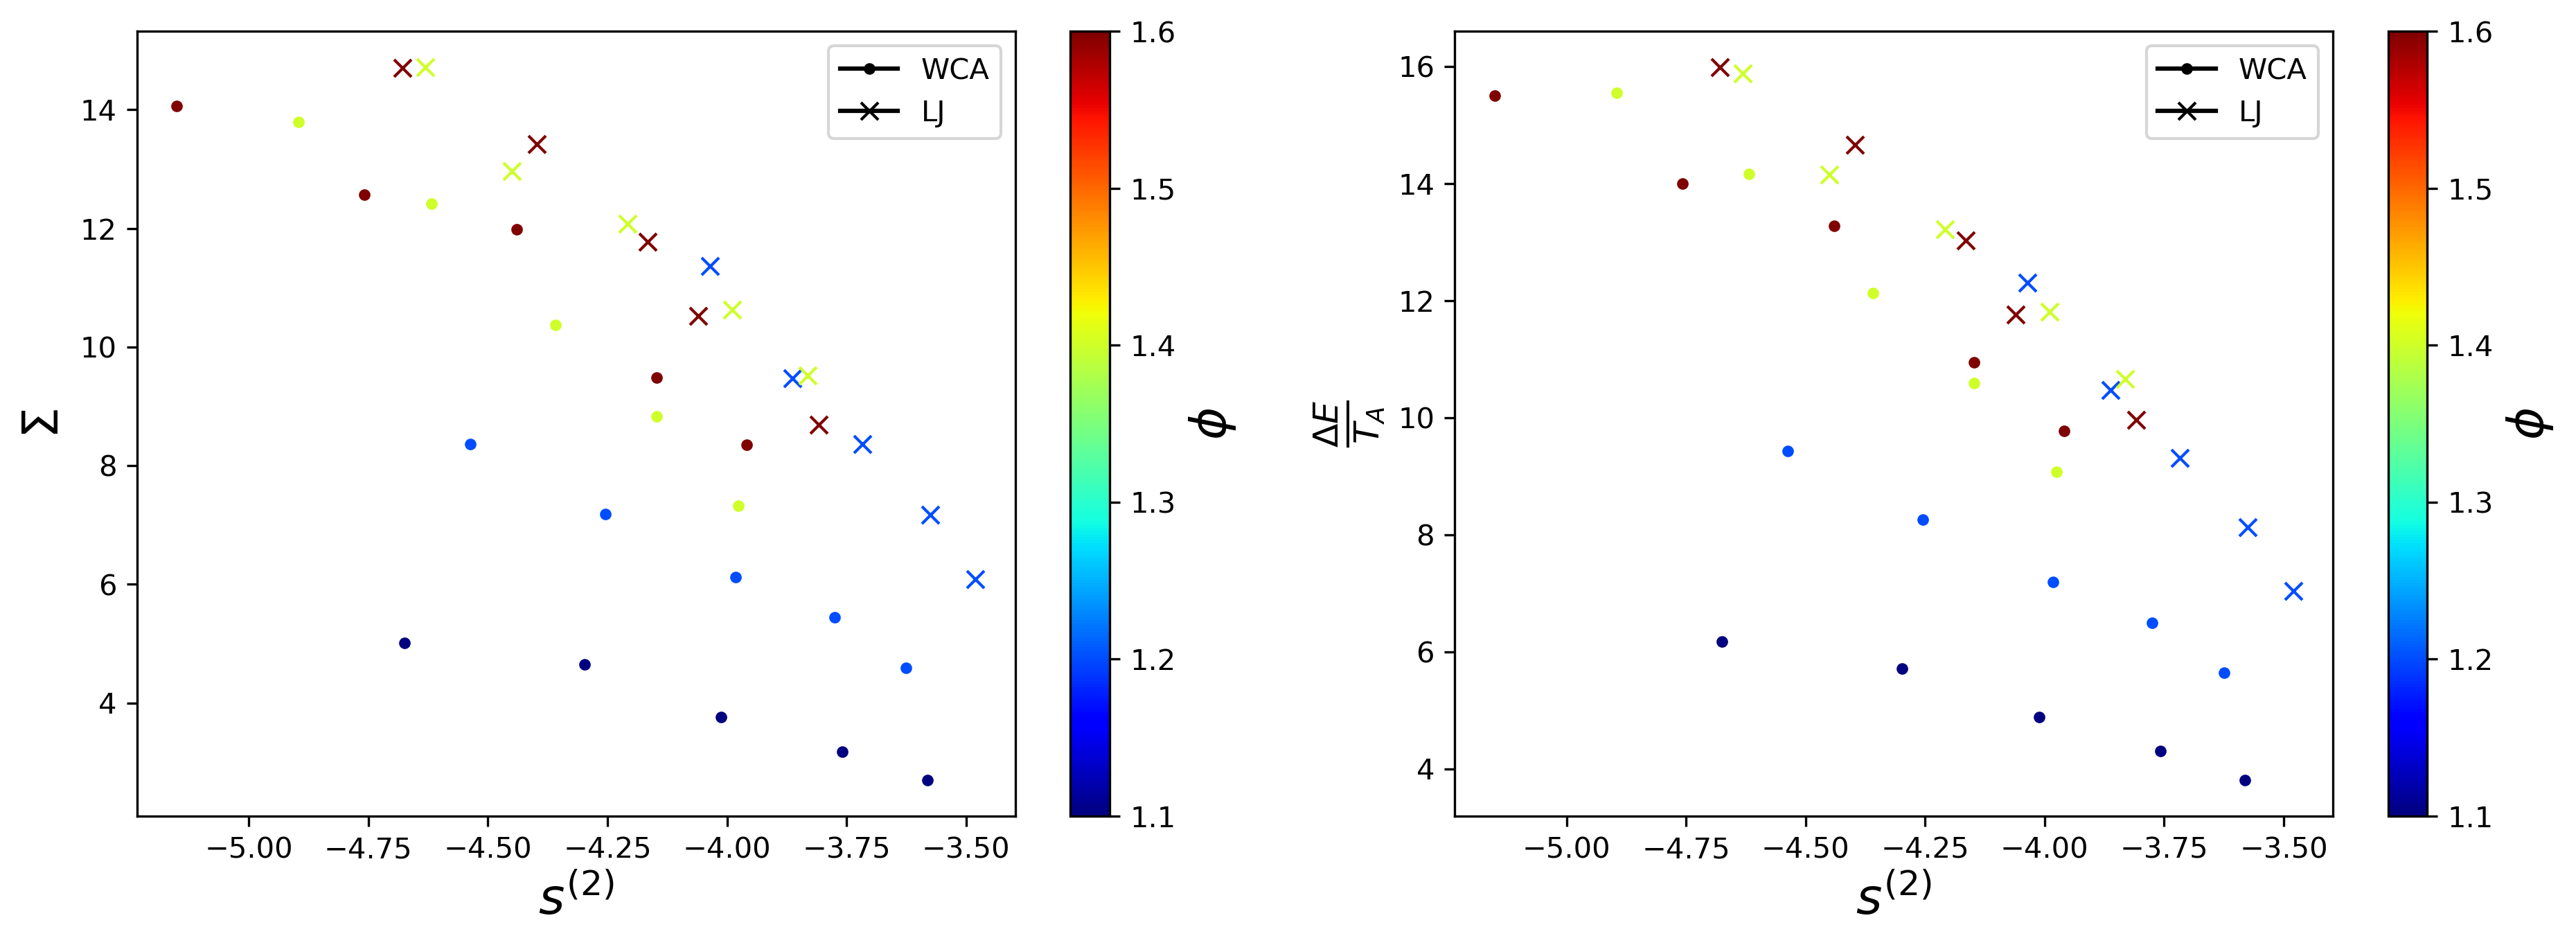

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

markers = {"KA_WCA": "s", "KA_LJ": "."}
cmap = cm.jet
norm = colors.Normalize(1.1, 1.6)

for job in project:
    if not job.isfile(f"analysis/rdfs-bin-softness.pickle"):
        continue
    file = job.fn(f"analysis/rdfs-bin-softness.pickle")

    data = pickle.load(open(file, "rb"))

    barrier_data = pickle.load(open(job.fn("analysis/barriers.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(barrier_data.keys())
    for i in range(len(keys)-1):
        v1 = barrier_data[keys[i]]
        for j in range(i+1, len(keys)):
            v2 = barrier_data[keys[j]]
            data1.append(-(v2["E"] - v1["E"]) / (v1["S"] - v2["S"]))
    T_a = np.mean(reject_outliers(pd.Series(data1)).to_numpy())

    itemps = data["inv_t"]
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = job.sp["rho"]
    for j in range(len(itemps))[-1:]:
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            tmp_temps = np.array(itemps)
            tmp_val = np.array(rearrang)
            mask = ~np.isnan(tmp_val)
            tmp_temps = tmp_temps[mask]
            tmp_val = tmp_val[mask]
            p = np.polyfit(tmp_temps, np.log(tmp_val), 1)

            fits.append(p)

        fits = np.array(fits)

        axs[0].plot(np.array(entropy), fits[:,1], markers[job.sp["pot"]], linestyle="", color=cmap(norm(phi)))
        axs[1].plot(np.array(entropy), -fits[:,0]/T_a, markers[job.sp["pot"]], linestyle="", color=cmap(norm(phi)))

axs[0].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[1].set_ylabel(r"$\frac{\Delta E}{T_A}$", size="xx-large")

plt.sca(axs[0])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\phi$")
custom_lines = [plt.Line2D([0], [0], color="k", marker=".", linestyle=None),
                plt.Line2D([0], [0], color="k", marker="x", linestyle=None)]
plt.legend(custom_lines, ["WCA", "LJ"])

plt.sca(axs[1])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\phi$")
plt.legend(custom_lines, ["WCA", "LJ"])

axs[1].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[0].set_ylabel(r"$\Sigma$", size="xx-large")

0.7707124260172878 -0.9596607031352148
[0.525 0.6   0.675 0.75 ]
0.598635337117289 -1.0631300052397399
[0.35 0.42 0.49 0.56]
2.620098481408399 -1.399867454201631
[1.8 2.  2.2 2.4]
2.6877761689264963 -1.2606983305424633
[2.  2.2 2.4 2.6]
0.3338363392795614 -1.1189144937146476
[0.16 0.2  0.24 0.28]
1.3072624046445487 -1.7481218023611111
[0.875 1.    1.125 1.25 ]
1.486096812105801 -1.1589598892757866
[1.    1.125 1.25  1.375]


Text(0, 0.5, '$\\frac{\\Sigma}{\\log\\left[P_R(T_A)\\right]}$')

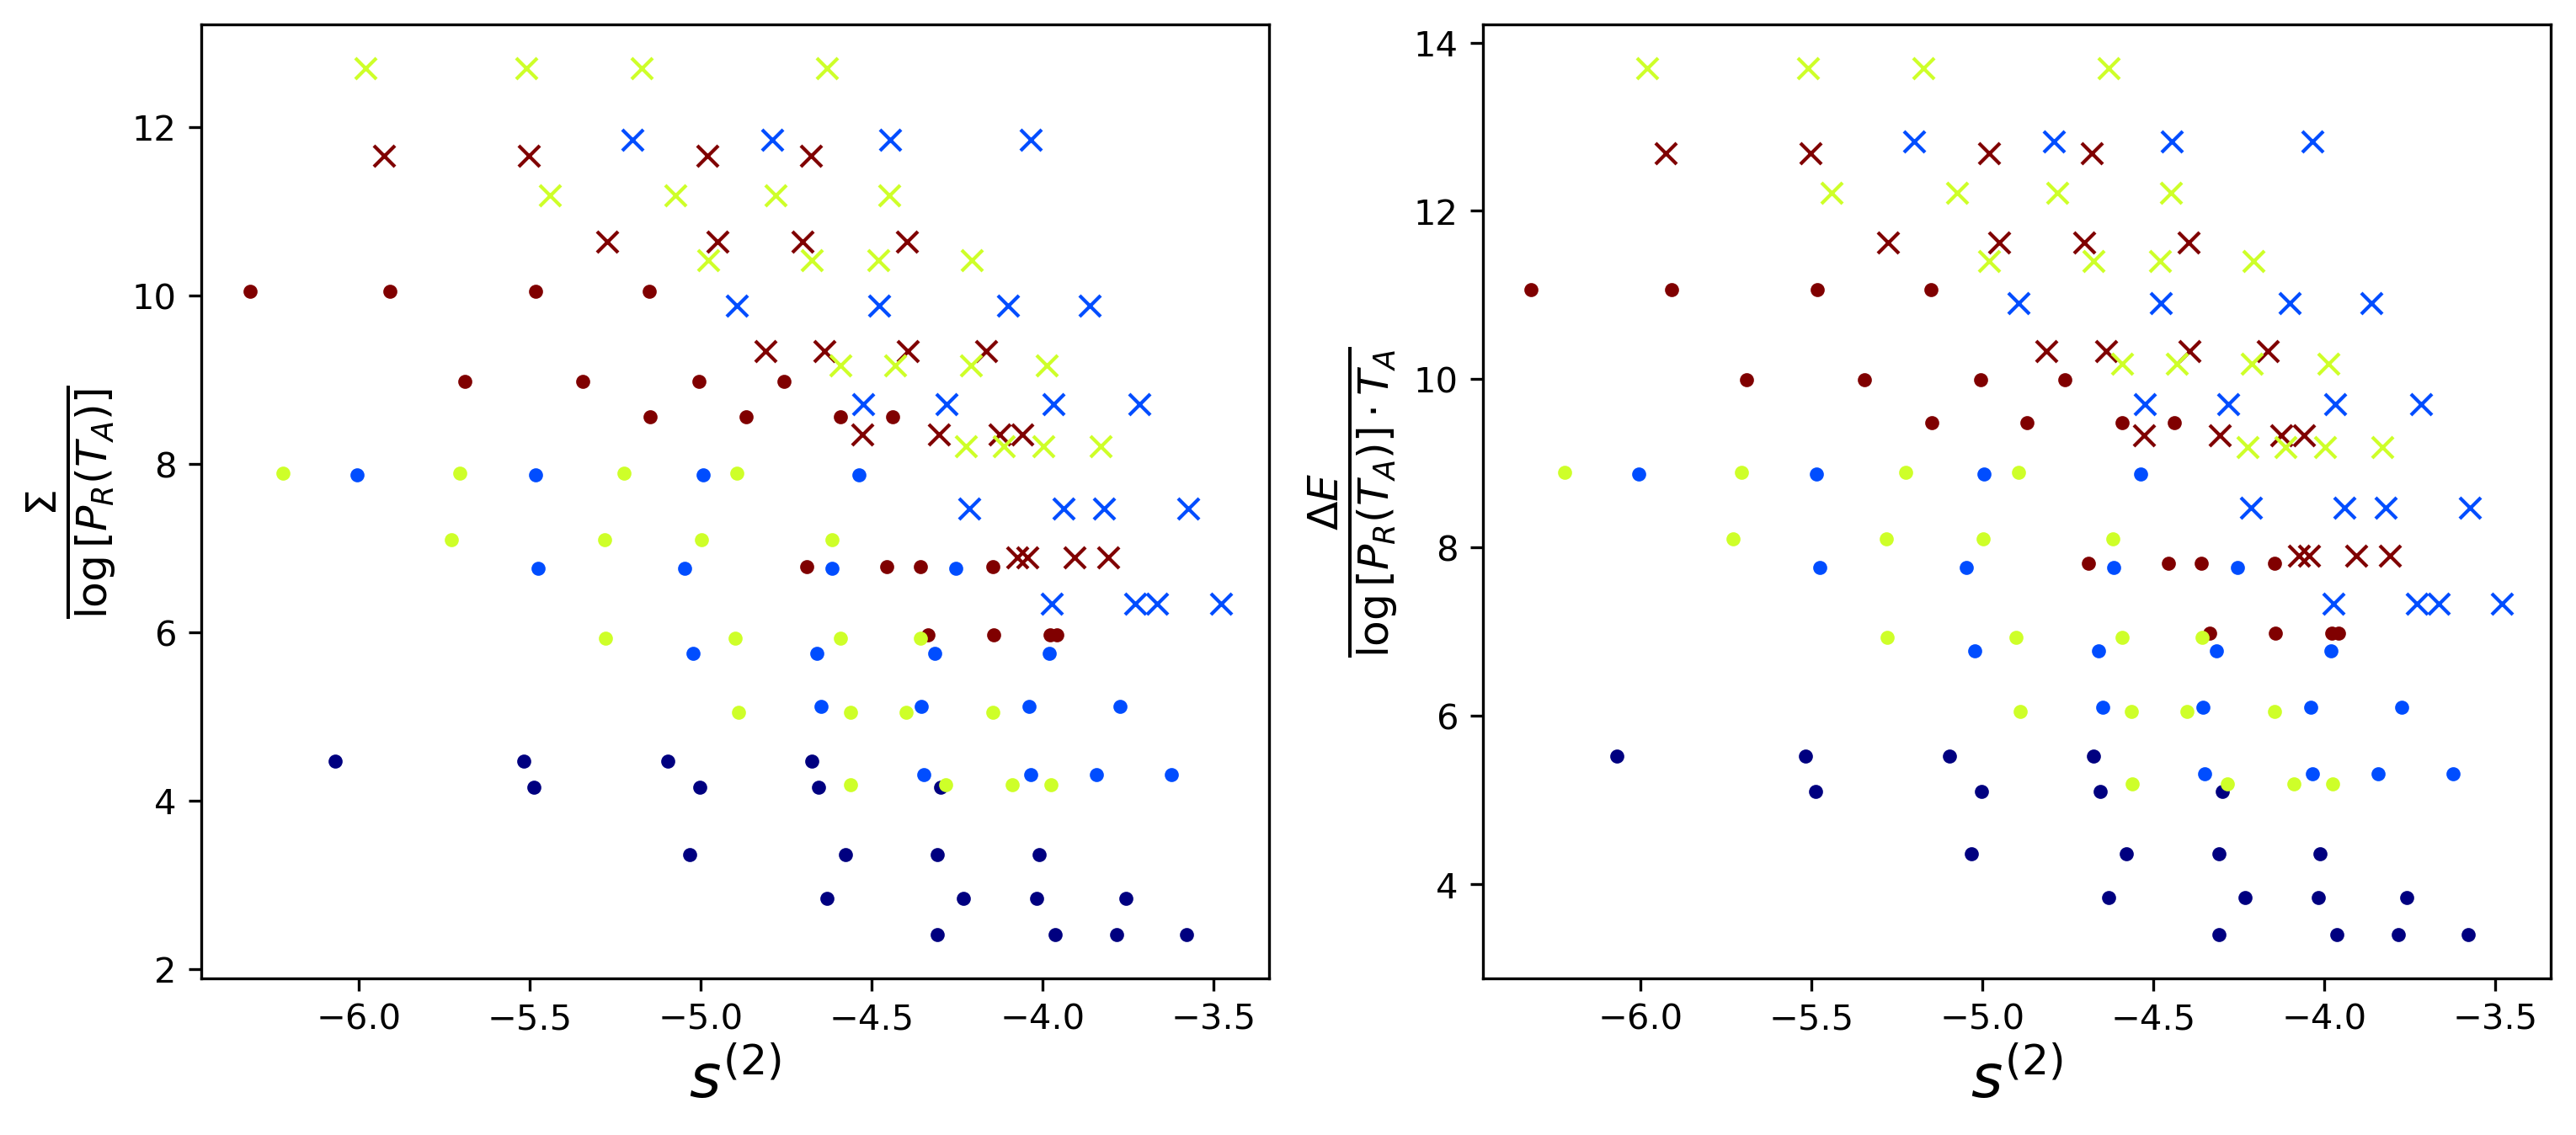

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

markers = {"KA_WCA": "s", "KA_LJ": "."}
cmap = cm.jet
norm = colors.Normalize(1.1, 1.6)

for job in project:
    if not job.isfile(f"analysis/rdfs-bin-softness.pickle"):
        continue
    file = job.fn(f"analysis/rdfs-bin-softness.pickle")

    data = pickle.load(open(file, "rb"))

    barrier_data = pickle.load(open(job.fn("analysis/barriers.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(barrier_data.keys())
    for i in range(len(keys)-1):
        v1 = barrier_data[keys[i]]
        for j in range(i+1, len(keys)):
            v2 = barrier_data[keys[j]]
            data1.append(-(v2["E"] - v1["E"]) / (v1["S"] - v2["S"]))
    T_a = np.mean(reject_outliers(pd.Series(data1)).to_numpy())

    P_rs = []
    for i in range(len(keys)):
        v1 = barrier_data[keys[i]]
        P_rs.append(np.exp(v1["S"] - v1["E"]/T_a))
    P_r = np.log(np.mean(P_rs))

    itemps = data["inv_t"]
    print(T_a, P_r)
    print(1/np.array(itemps))
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = job.sp["rho"]
    for j in range(len(itemps)):
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            tmp_temps = np.array(itemps)
            tmp_val = np.array(rearrang)
            mask = ~np.isnan(tmp_val)
            tmp_temps = tmp_temps[mask]
            tmp_val = tmp_val[mask]
            p = np.polyfit(tmp_temps, np.log(tmp_val), 1)

            fits.append(p)

        fits = np.array(fits)

        axs[0].plot(np.array(entropy), -fits[:,1]/P_r, markers[job.sp["pot"]], linestyle="", color=cmap(norm(phi)))
        axs[1].plot(np.array(entropy), fits[:,0]/P_r/T_a, markers[job.sp["pot"]], linestyle="", color=cmap(norm(phi)))

axs[0].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[1].set_ylabel(r"$\frac{\Delta E}{\log\left[P_R(T_A)\right] \cdot T_A}$", size="xx-large")

axs[1].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[0].set_ylabel(r"$\frac{\Sigma}{\log\left[P_R(T_A)\right]}$", size="xx-large")

[0.68118793 0.77850049 0.87581305 0.97312561]
[0.58466311 0.70159574 0.81852836 0.93546098]
[0.68699708 0.76333009 0.83966309 0.9159961 ]
[0.74410958 0.81852054 0.8929315  0.96734246]
[0.47927676 0.59909595 0.71891514 0.83873433]
[0.66933769 0.76495736 0.86057703 0.9561967 ]
[0.67290367 0.75701663 0.84112959 0.92524255]


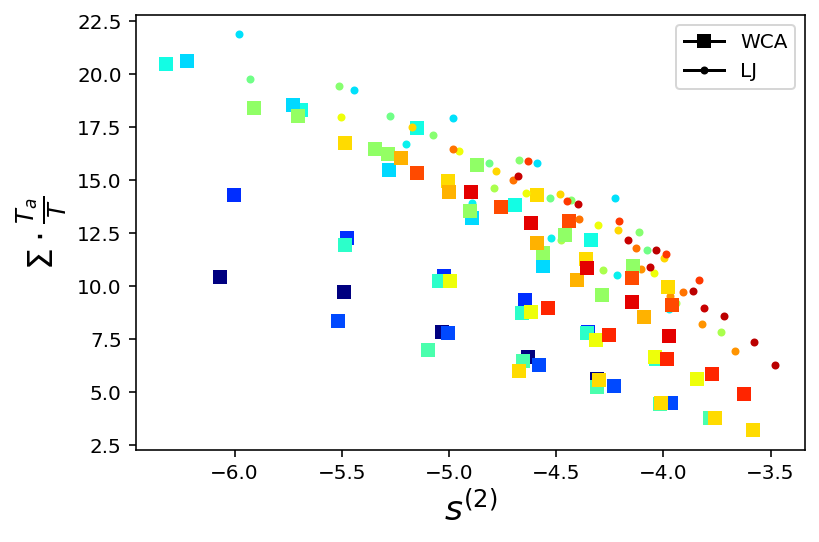

In [13]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
plt.figure()
cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

markers = {"KA_WCA": "s", "KA_LJ": "."}
cmap = cm.jet
norm = colors.Normalize(0.5, 1.0)

for job in project:
    if not job.isfile(f"analysis/rdfs-bin-softness.pickle"):
        continue
    file = job.fn(f"analysis/rdfs-bin-softness.pickle")

    data = pickle.load(open(file, "rb"))

    barrier_data = pickle.load(open(job.fn("analysis/barriers.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(barrier_data.keys())
    for i in range(len(keys)-1):
        v1 = barrier_data[keys[i]]
        for j in range(i+1, len(keys)):
            v2 = barrier_data[keys[j]]
            data1.append(-(v2["E"] - v1["E"]) / (v1["S"] - v2["S"]))
    T_a = np.mean(reject_outliers(pd.Series(data1)).to_numpy())

    P_rs = []
    for i in range(len(keys)):
        v1 = barrier_data[keys[i]]
        P_rs.append(np.exp(v1["S"] - v1["E"]/T_a))
    P_r = np.log(np.mean(P_rs))

    itemps = data["inv_t"]
    temp_ratios = 1/np.array(itemps)/T_a
    print(temp_ratios)
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = job.sp["rho"]
    for j in range(len(itemps)):
        fits = []
        entropy = []
        real_temp = 1/itemps[j]
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            tmp_temps = np.array(itemps)
            tmp_val = np.array(rearrang)
            mask = ~np.isnan(tmp_val)
            tmp_temps = tmp_temps[mask]
            tmp_val = tmp_val[mask]
            p = np.polyfit(tmp_temps, np.log(tmp_val), 1)

            fits.append(p)

        fits = np.array(fits)

        plt.plot(np.array(entropy), fits[:,1]*(T_a/real_temp), markers[job.sp["pot"]], linestyle="", color=cmap(norm(temp_ratios[j])))
        # axs[1].plot(np.array(entropy), -fits[:,0]/T_a, markers[job.sp["pot"]], linestyle="", color=cmap(norm(temp_ratios[j])))

plt.xlabel(r"$s^{(2)}$", size="xx-large")
plt.ylabel(r"$\Sigma\cdot\frac{T_a}{T}$", size="xx-large")
custom_lines = [plt.Line2D([0], [0], color="k", marker="s", linestyle=None),
                plt.Line2D([0], [0], color="k", marker=".", linestyle=None)]
plt.legend(custom_lines, ["WCA", "LJ"])

[0.68118793 0.77850049 0.87581305 0.97312561]
[0.58466311 0.70159574 0.81852836 0.93546098]
[0.68699708 0.76333009 0.83966309 0.9159961 ]
[0.74410958 0.81852054 0.8929315  0.96734246]
[0.47927676 0.59909595 0.71891514 0.83873433]
[0.66933769 0.76495736 0.86057703 0.9561967 ]
[0.67290367 0.75701663 0.84112959 0.92524255]


Text(0.5, 0, '$\\frac{T}{T_A}$')

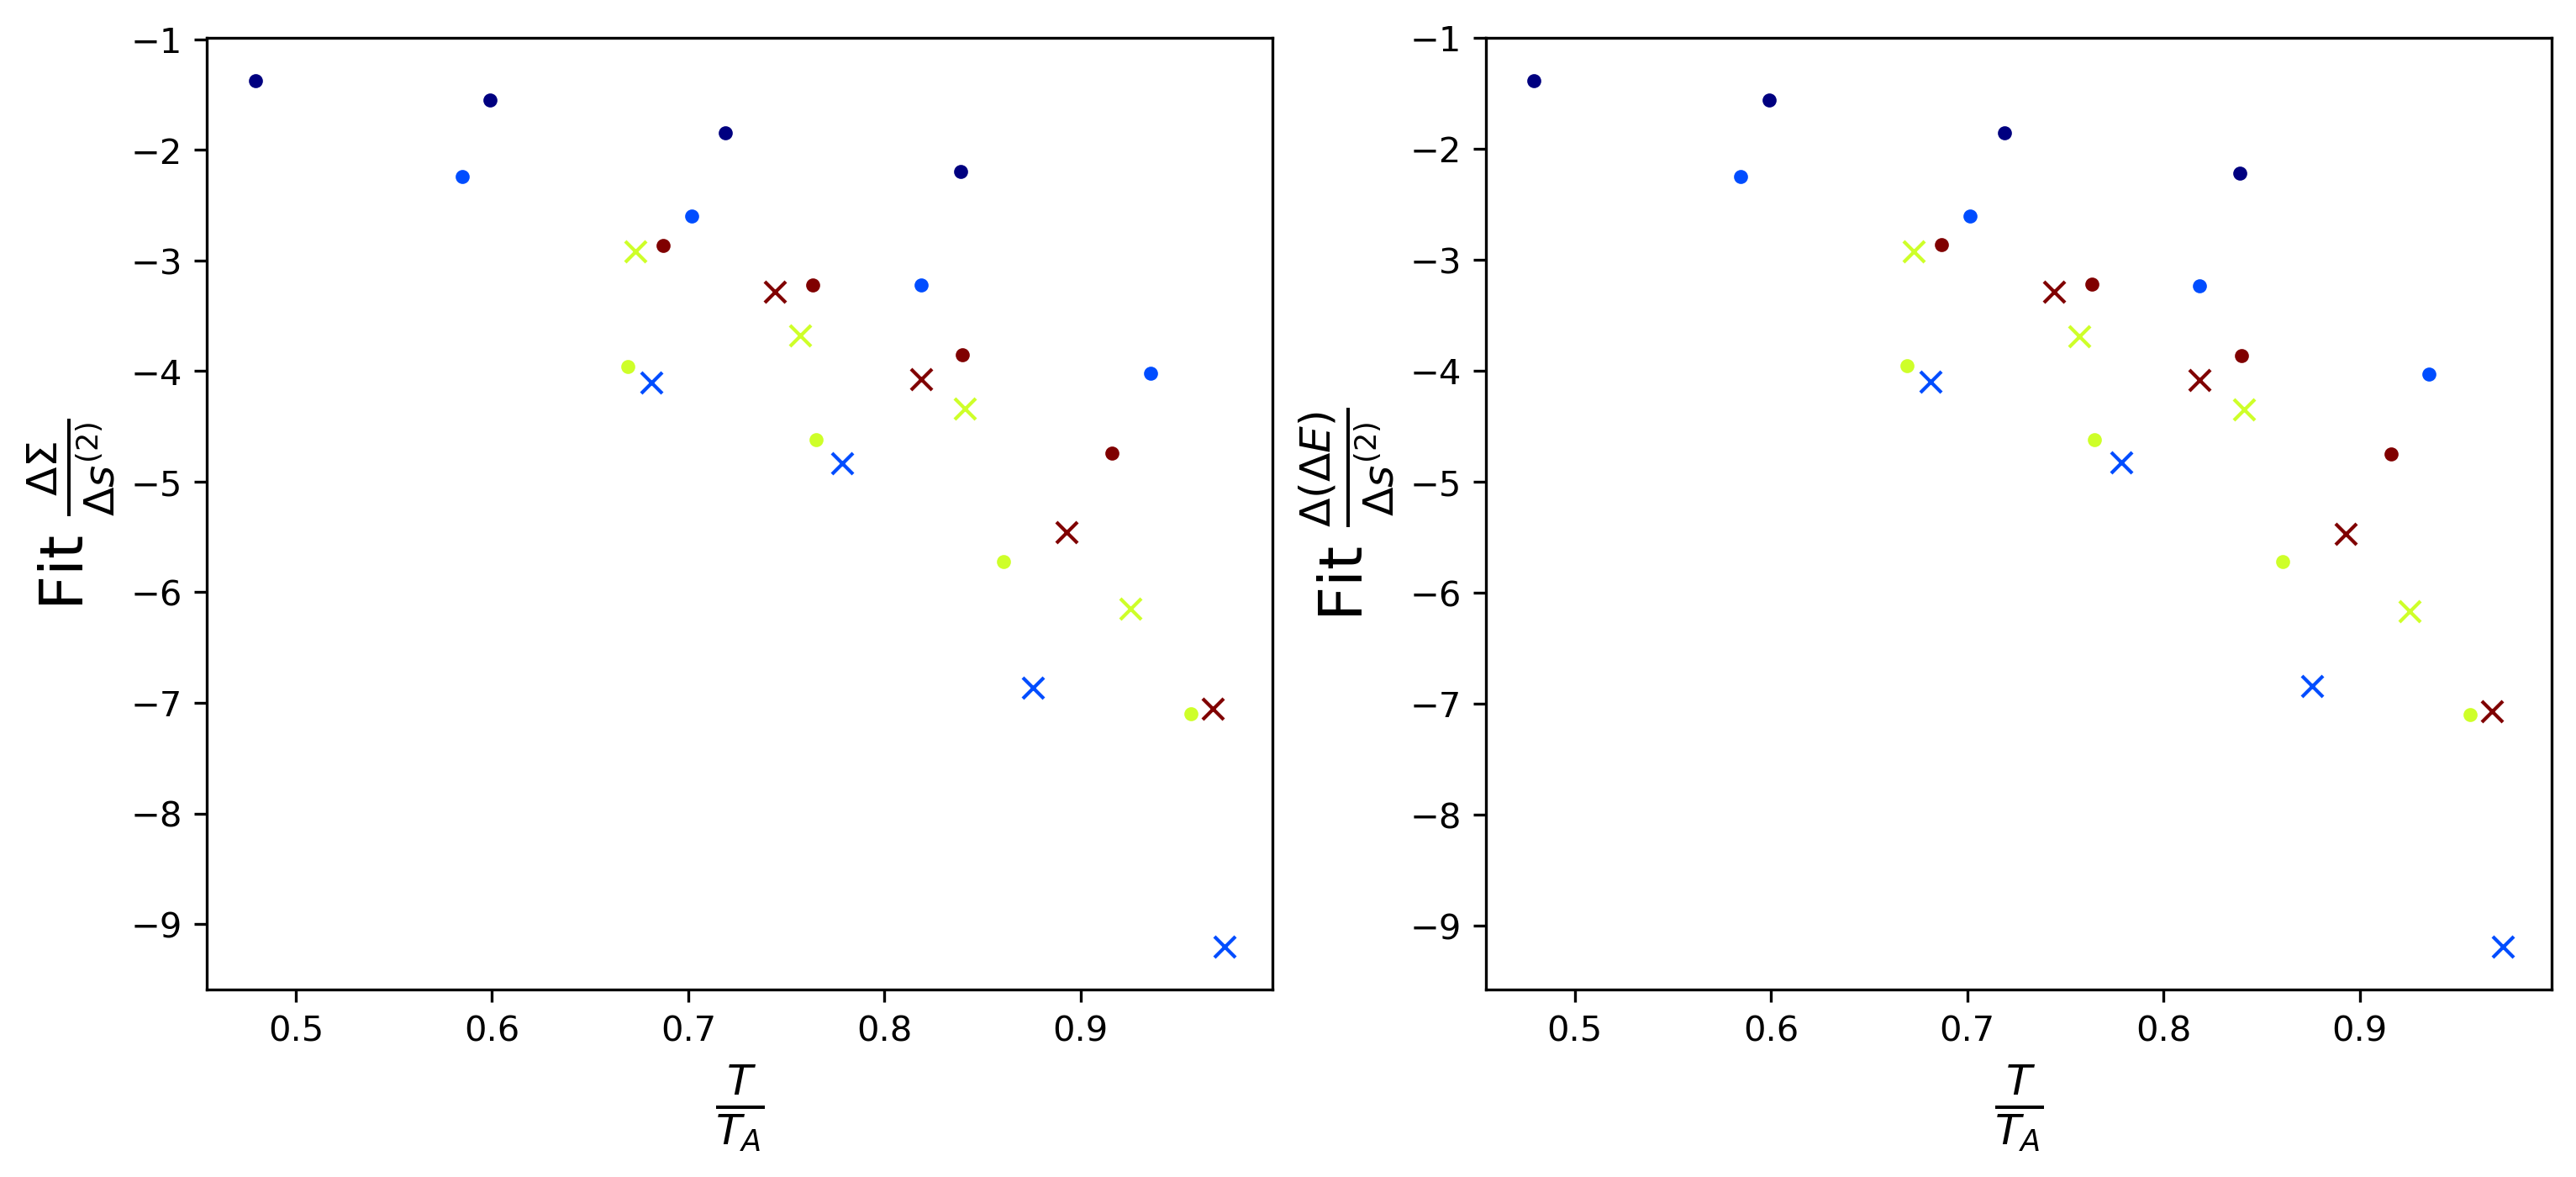

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

markers = {"KA_WCA": ".", "KA_LJ": "x"}
cmap = cm.jet
norm = colors.Normalize(1.1, 1.6)

for job in project:
    if not job.isfile(f"analysis/rdfs-bin-softness.pickle"):
        continue
    file = job.fn(f"analysis/rdfs-bin-softness.pickle")

    data = pickle.load(open(file, "rb"))

    barrier_data = pickle.load(open(job.fn("analysis/barriers.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(barrier_data.keys())
    for i in range(len(keys)-1):
        v1 = barrier_data[keys[i]]
        for j in range(i+1, len(keys)):
            v2 = barrier_data[keys[j]]
            data1.append(-(v2["E"] - v1["E"]) / (v1["S"] - v2["S"]))
    T_a = np.mean(reject_outliers(pd.Series(data1)).to_numpy())

    P_rs = []
    for i in range(len(keys)):
        v1 = barrier_data[keys[i]]
        P_rs.append(np.exp(v1["S"] - v1["E"]/T_a))
    P_r = np.log(np.mean(P_rs))

    itemps = data["inv_t"]
    temp_ratios = 1/np.array(itemps)/T_a
    print(temp_ratios)
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = job.sp["rho"]
    for j in range(len(itemps)):
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            tmp_temps = np.array(itemps)
            tmp_val = np.array(rearrang)
            mask = ~np.isnan(tmp_val)
            tmp_temps = tmp_temps[mask]
            tmp_val = tmp_val[mask]
            p = np.polyfit(tmp_temps, np.log(tmp_val), 1)

            fits.append(p)

        fits = np.array(fits)

        p = np.polyfit(np.array(entropy), fits[:,1], 1)

        axs[0].plot(temp_ratios[j], p[0], markers[job.sp["pot"]], linestyle="", color=cmap(norm(phi)))

        p = np.polyfit(np.array(entropy), -fits[:,0]/T_a, 1)
        axs[1].plot(temp_ratios[j], p[0], markers[job.sp["pot"]], linestyle="", color=cmap(norm(phi)))

axs[0].set_ylabel(r"Fit $\frac{\Delta \Sigma}{\Delta s^{(2)}}$", size="xx-large")
axs[0].set_xlabel(r"$\frac{T}{T_A}$", size="xx-large")

axs[1].set_ylabel(r"Fit $\frac{\Delta \left(\Delta E\right)}{\Delta s^{(2)}}$", size="xx-large")
axs[1].set_xlabel(r"$\frac{T}{T_A}$", size="xx-large")

0.7707124260172878 -0.9596607031352148
[0.525 0.6   0.675 0.75 ]
0.598635337117289 -1.0631300052397399
[0.35 0.42 0.49 0.56]
2.620098481408399 -1.399867454201631
[1.8 2.  2.2 2.4]
2.6877761689264963 -1.2606983305424633
[2.  2.2 2.4 2.6]
0.3338363392795614 -1.1189144937146476
[0.16 0.2  0.24 0.28]
1.3072624046445487 -1.7481218023611111
[0.875 1.    1.125 1.25 ]
1.486096812105801 -1.1589598892757866
[1.    1.125 1.25  1.375]


Text(0, 0.5, '$\\frac{\\Sigma}{\\log\\left[P_R(T_A)\\right]}$')

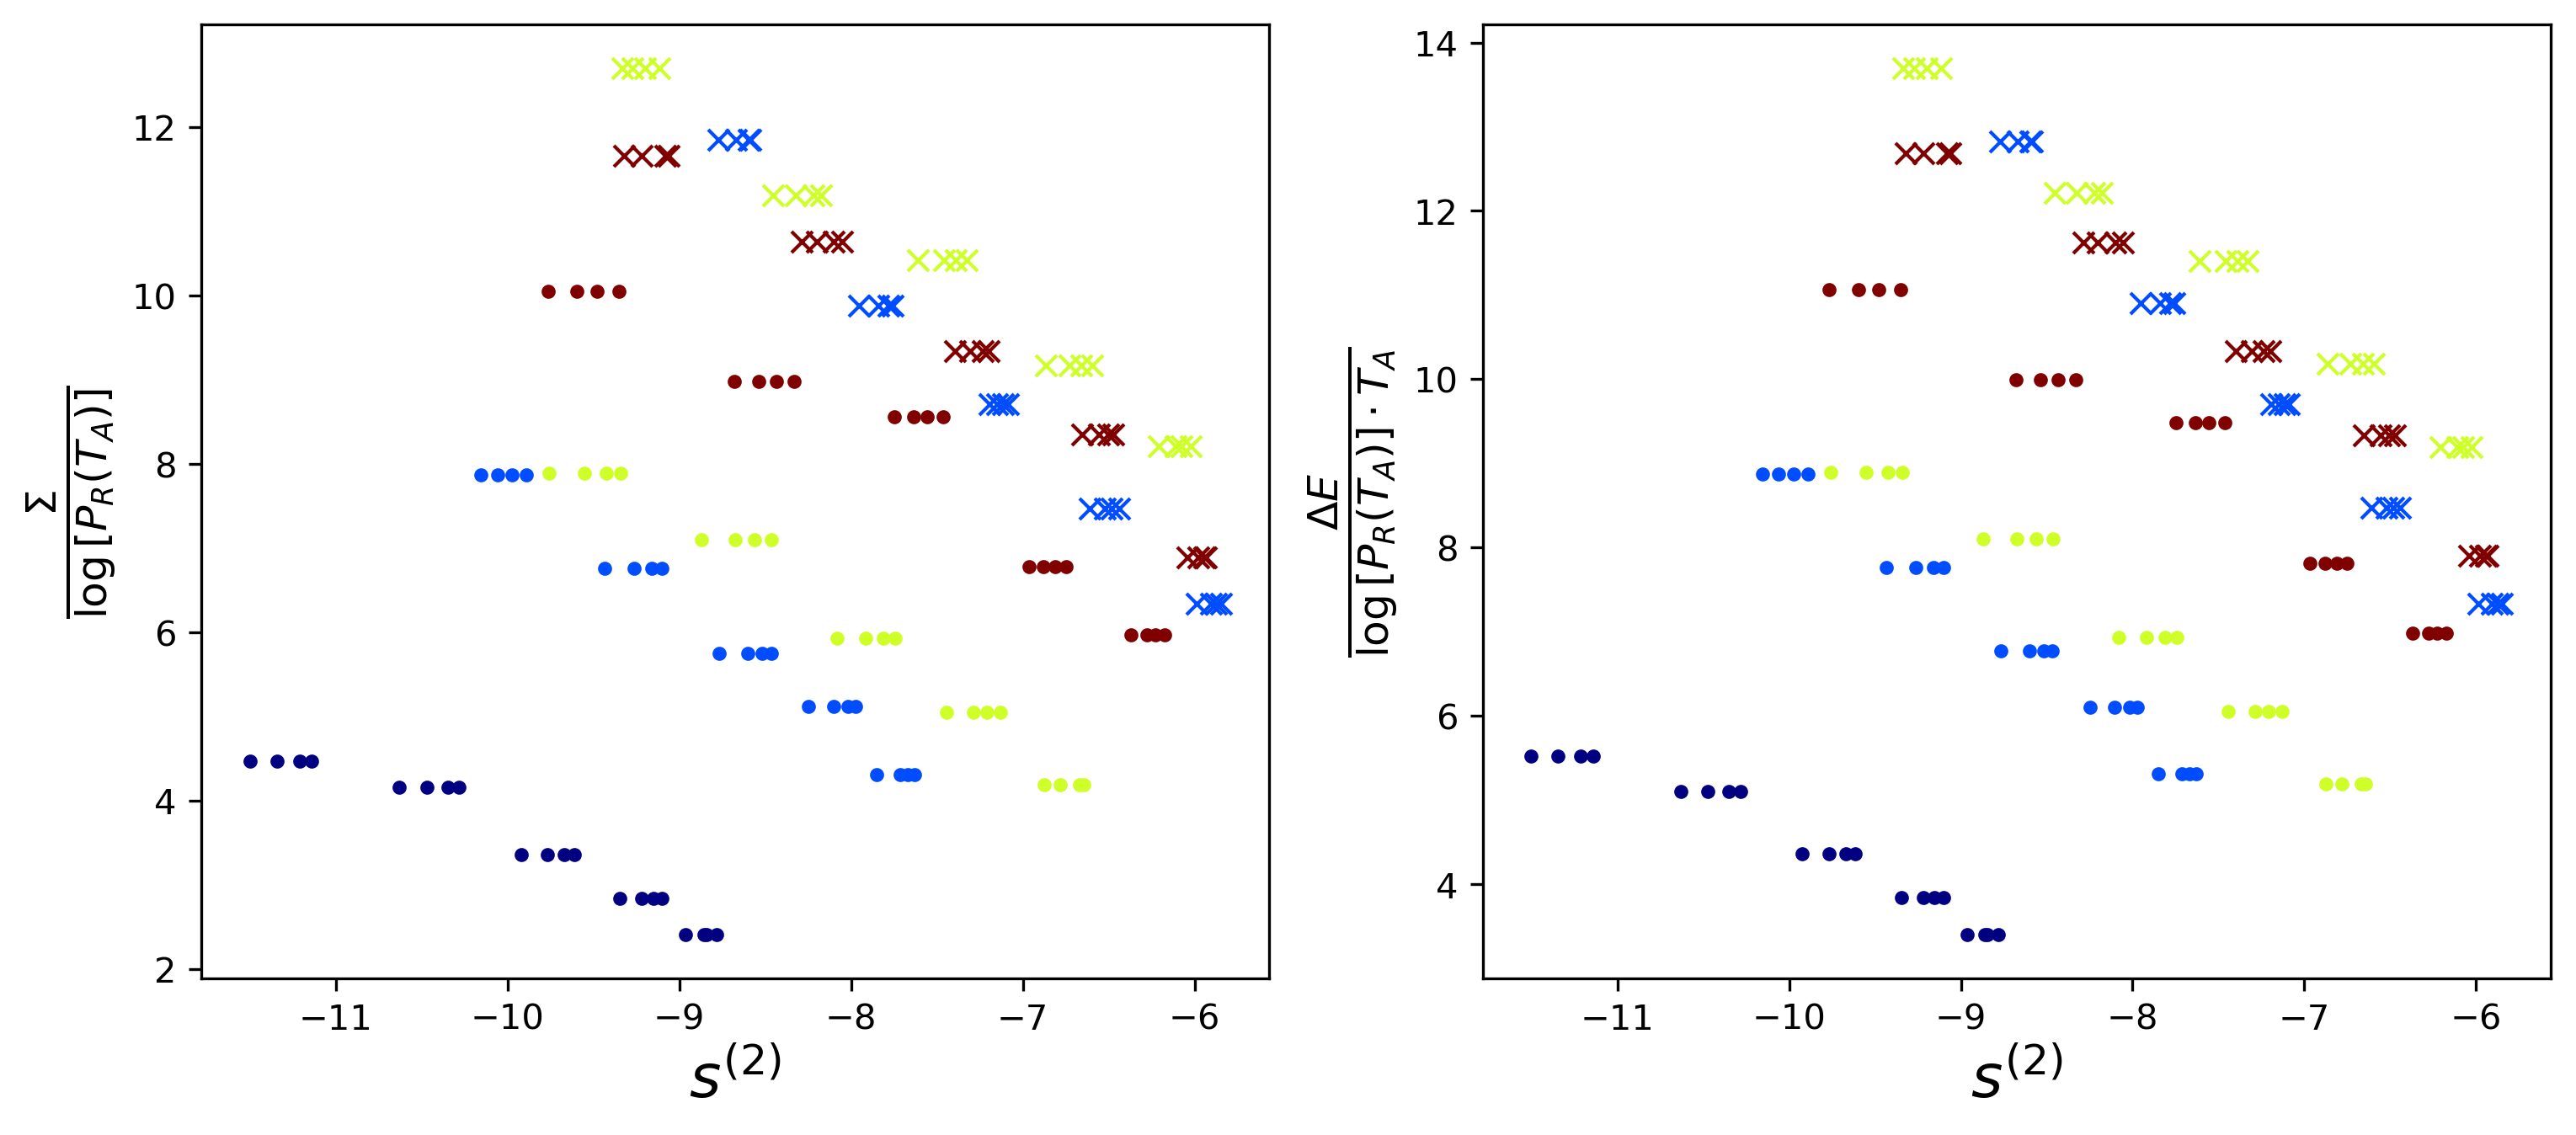

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

markers = {"KA_WCA": ".", "KA_LJ": "x"}
cmap = cm.jet
norm = colors.Normalize(1.1, 1.6)

for job in project:
    if not job.isfile(f"analysis/rdfs-bin-softness-fire.pickle"):
        continue
    file = job.fn(f"analysis/rdfs-bin-softness-fire.pickle")

    data = pickle.load(open(file, "rb"))

    barrier_data = pickle.load(open(job.fn("analysis/barriers.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(barrier_data.keys())
    for i in range(len(keys)-1):
        v1 = barrier_data[keys[i]]
        for j in range(i+1, len(keys)):
            v2 = barrier_data[keys[j]]
            data1.append(-(v2["E"] - v1["E"]) / (v1["S"] - v2["S"]))
    T_a = np.mean(reject_outliers(pd.Series(data1)).to_numpy())

    P_rs = []
    for i in range(len(keys)):
        v1 = barrier_data[keys[i]]
        P_rs.append(np.exp(v1["S"] - v1["E"]/T_a))
    P_r = np.log(np.mean(P_rs))

    itemps = data["inv_t"]
    print(T_a, P_r)
    print(1/np.array(itemps))
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = job.sp["rho"]
    for j in range(len(itemps)):
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            tmp_temps = np.array(itemps)
            tmp_val = np.array(rearrang)
            mask = ~np.isnan(tmp_val)
            tmp_temps = tmp_temps[mask]
            tmp_val = tmp_val[mask]
            p = np.polyfit(tmp_temps, np.log(tmp_val), 1)

            fits.append(p)

        fits = np.array(fits)

        axs[0].plot(np.array(entropy), -fits[:,1]/P_r, markers[job.sp["pot"]], linestyle="", color=cmap(norm(phi)))
        axs[1].plot(np.array(entropy), fits[:,0]/P_r/T_a, markers[job.sp["pot"]], linestyle="", color=cmap(norm(phi)))

axs[0].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[1].set_ylabel(r"$\frac{\Delta E}{\log\left[P_R(T_A)\right] \cdot T_A}$", size="xx-large")

axs[1].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[0].set_ylabel(r"$\frac{\Sigma}{\log\left[P_R(T_A)\right]}$", size="xx-large")

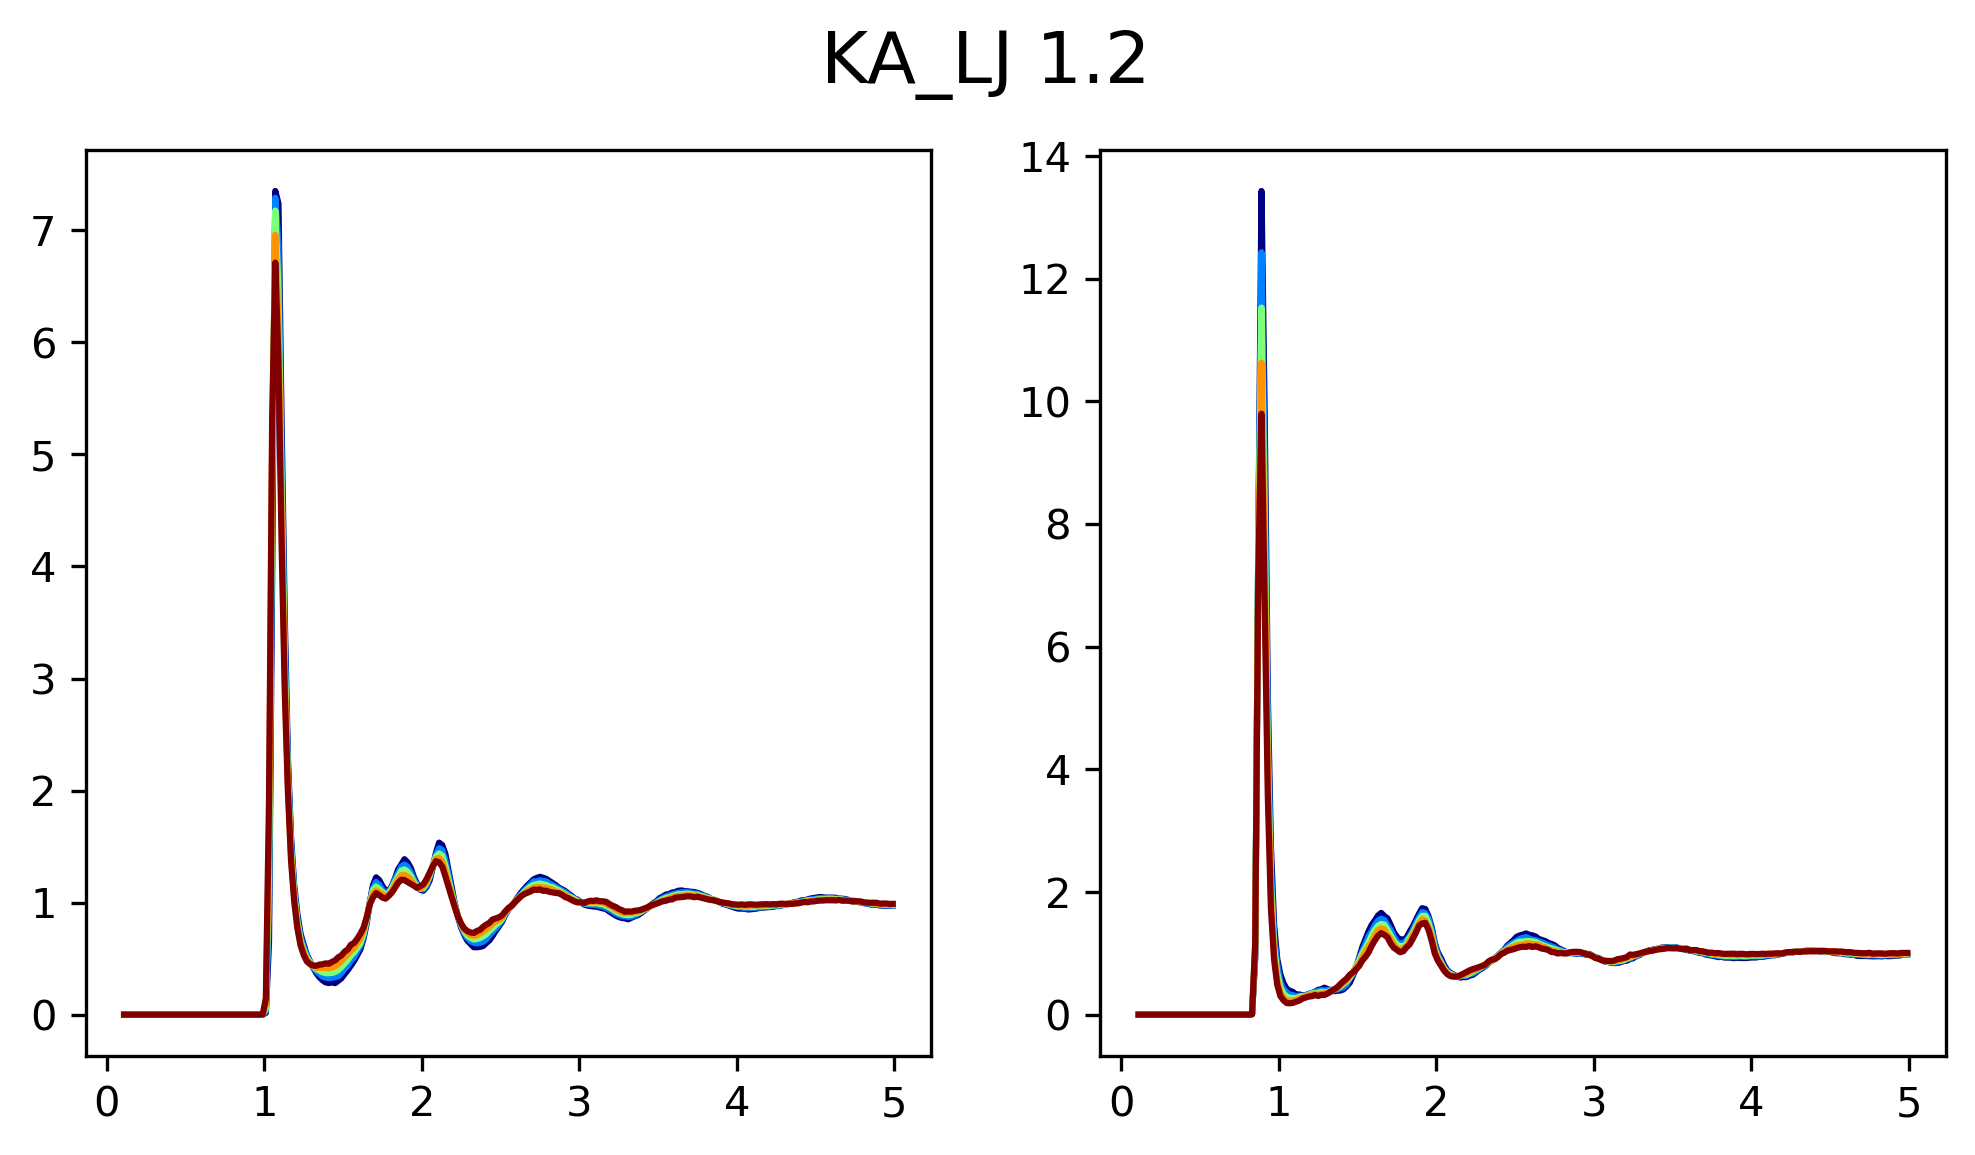

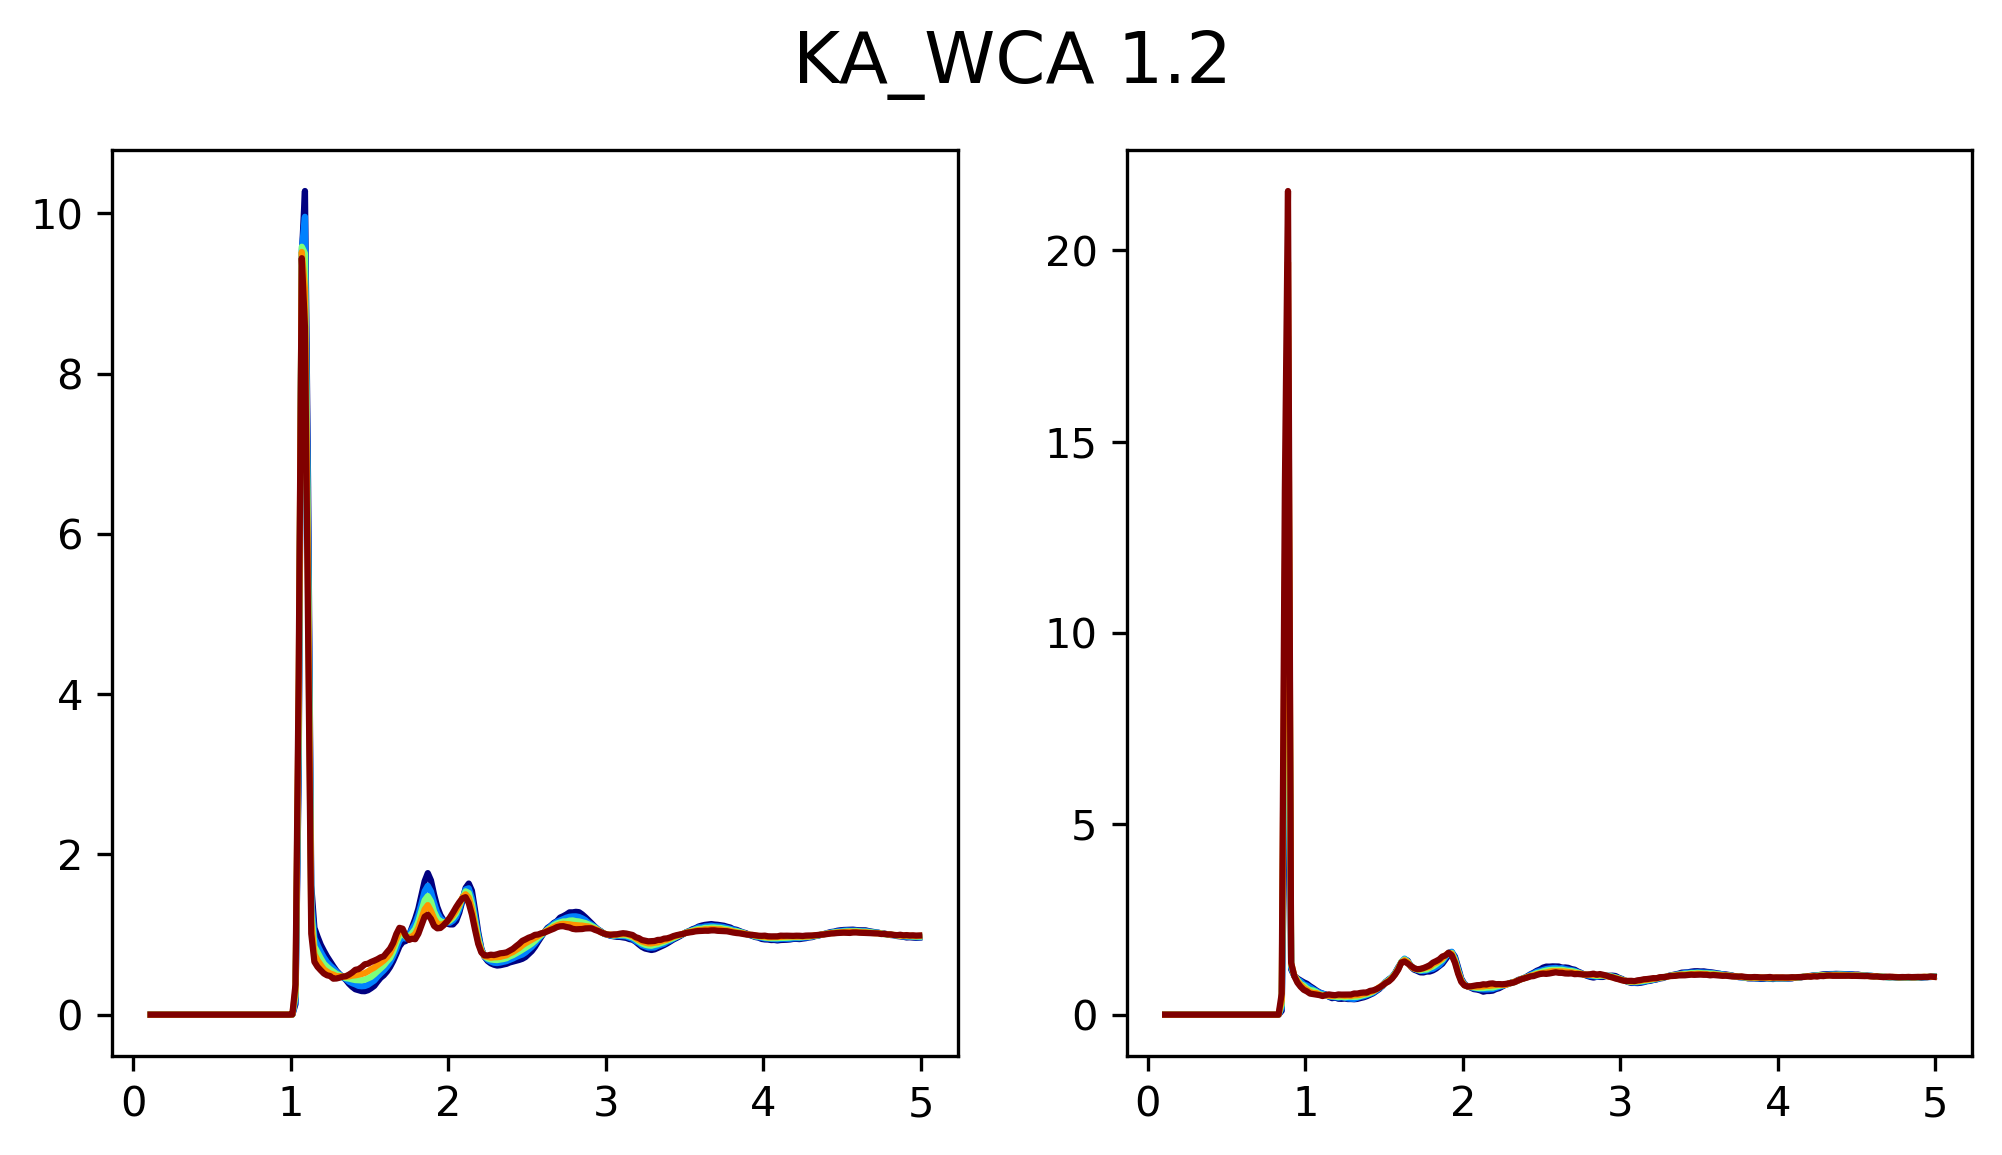

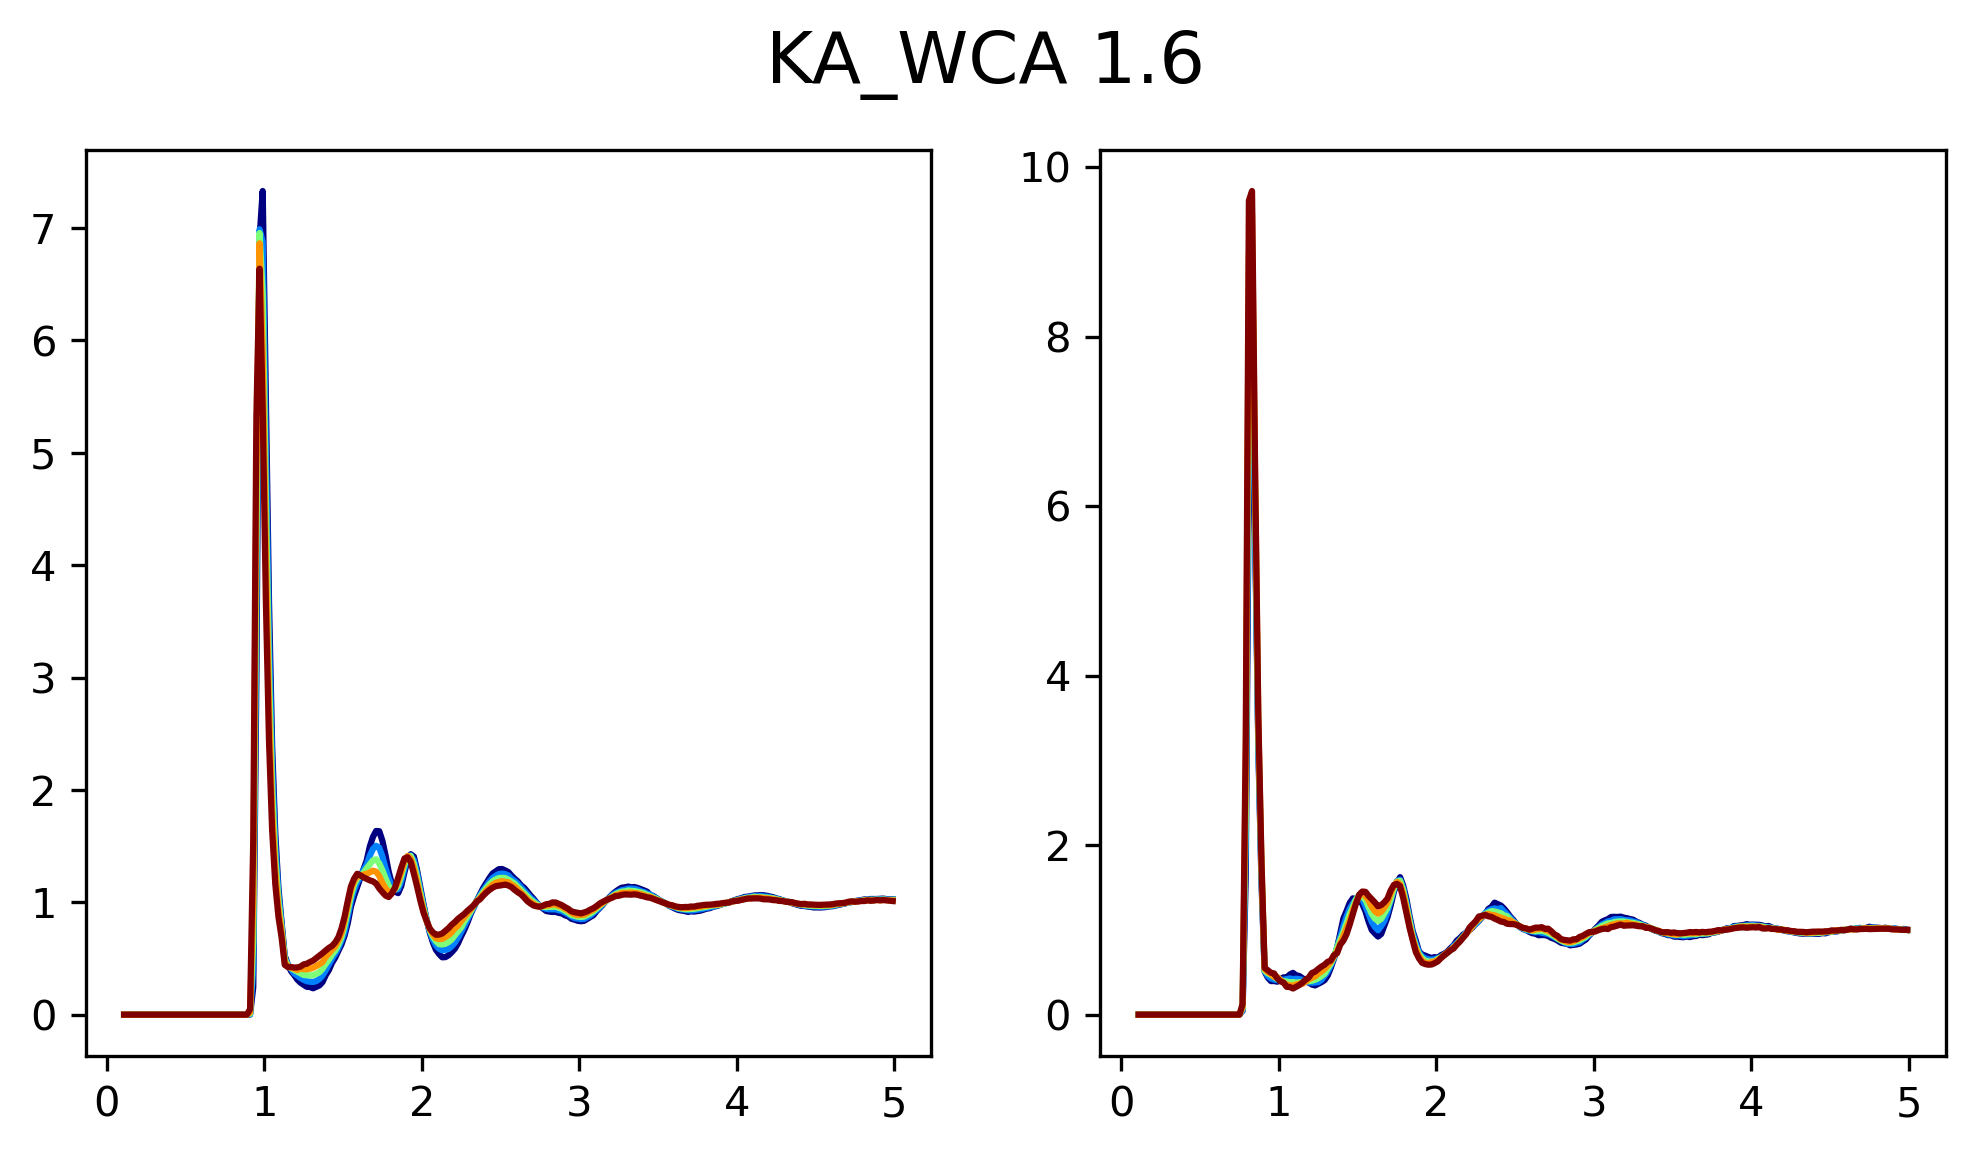

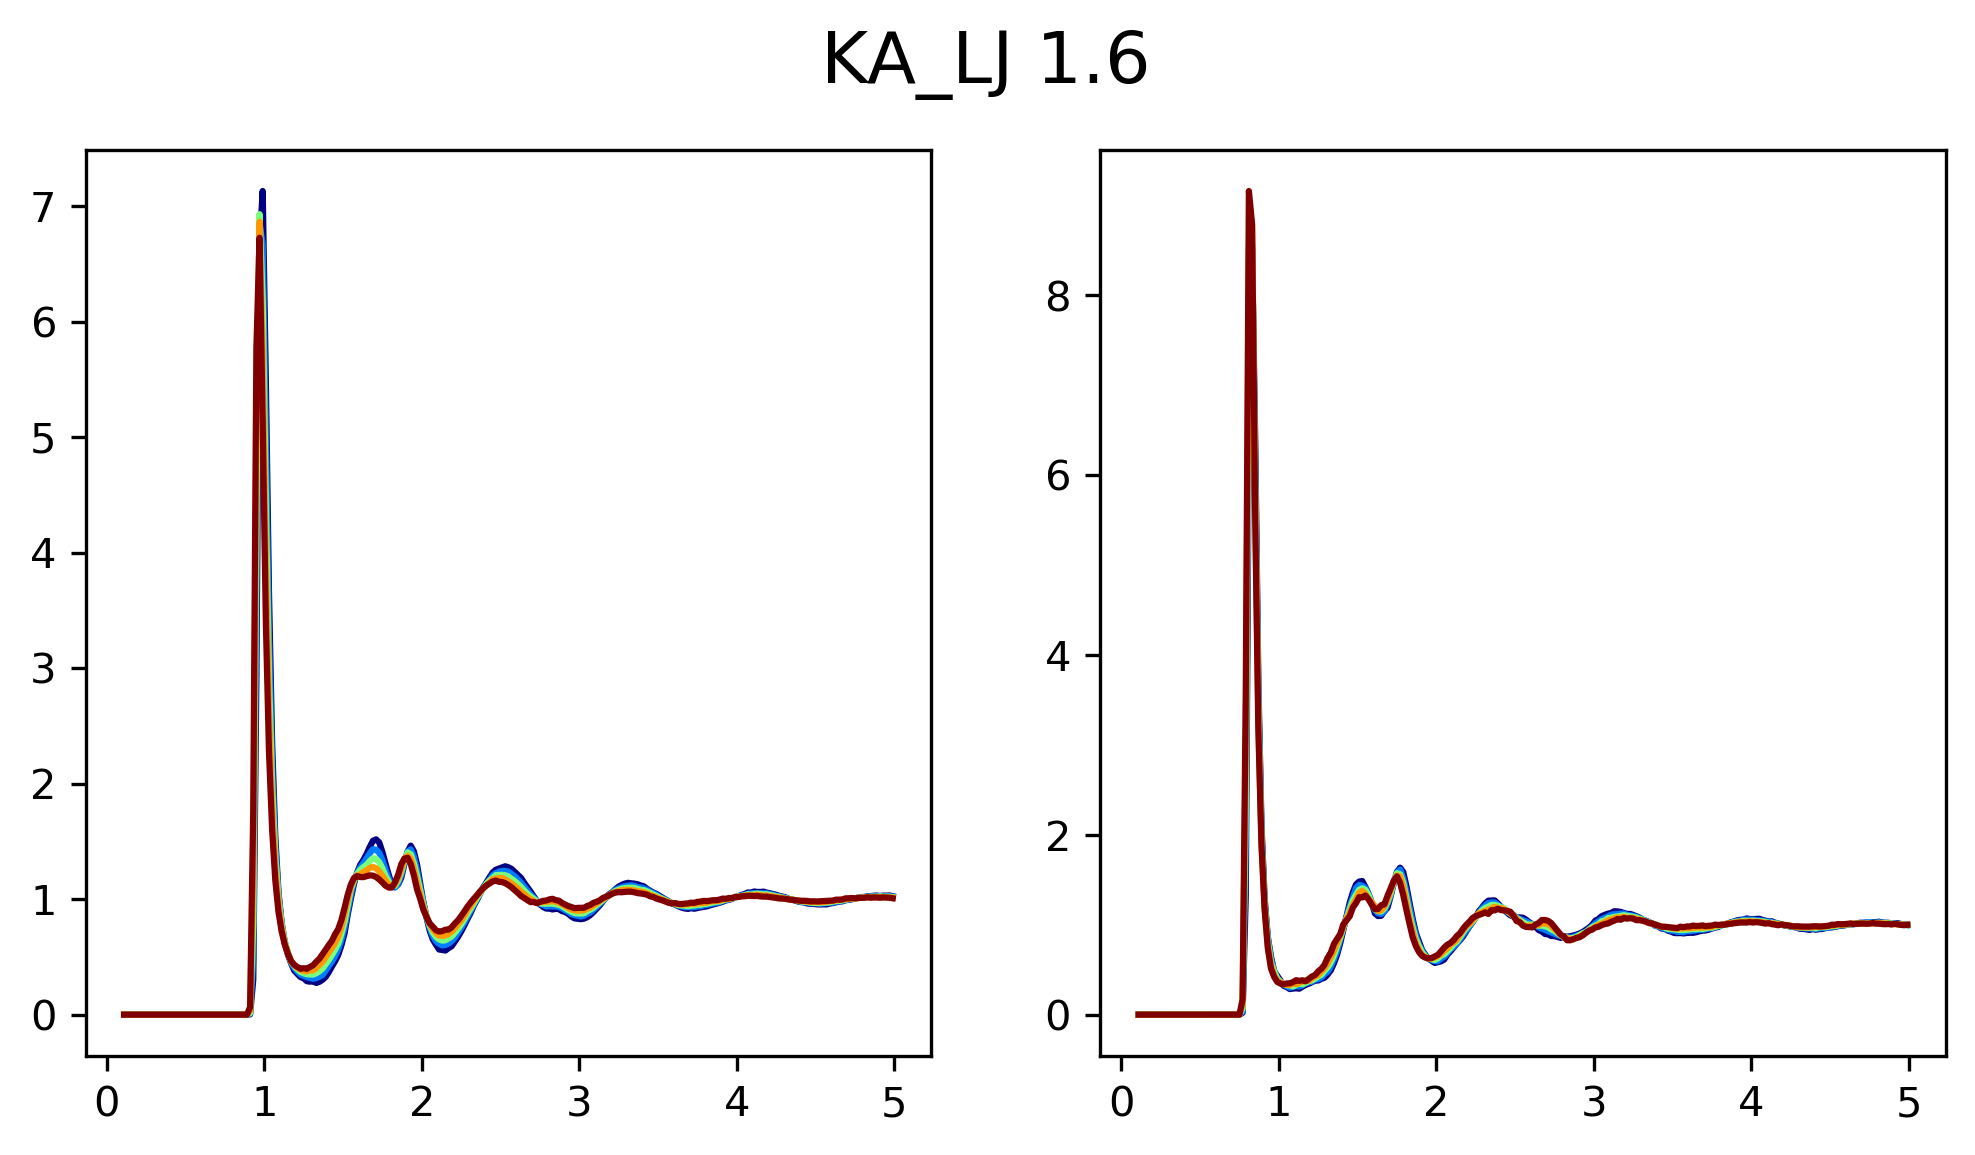

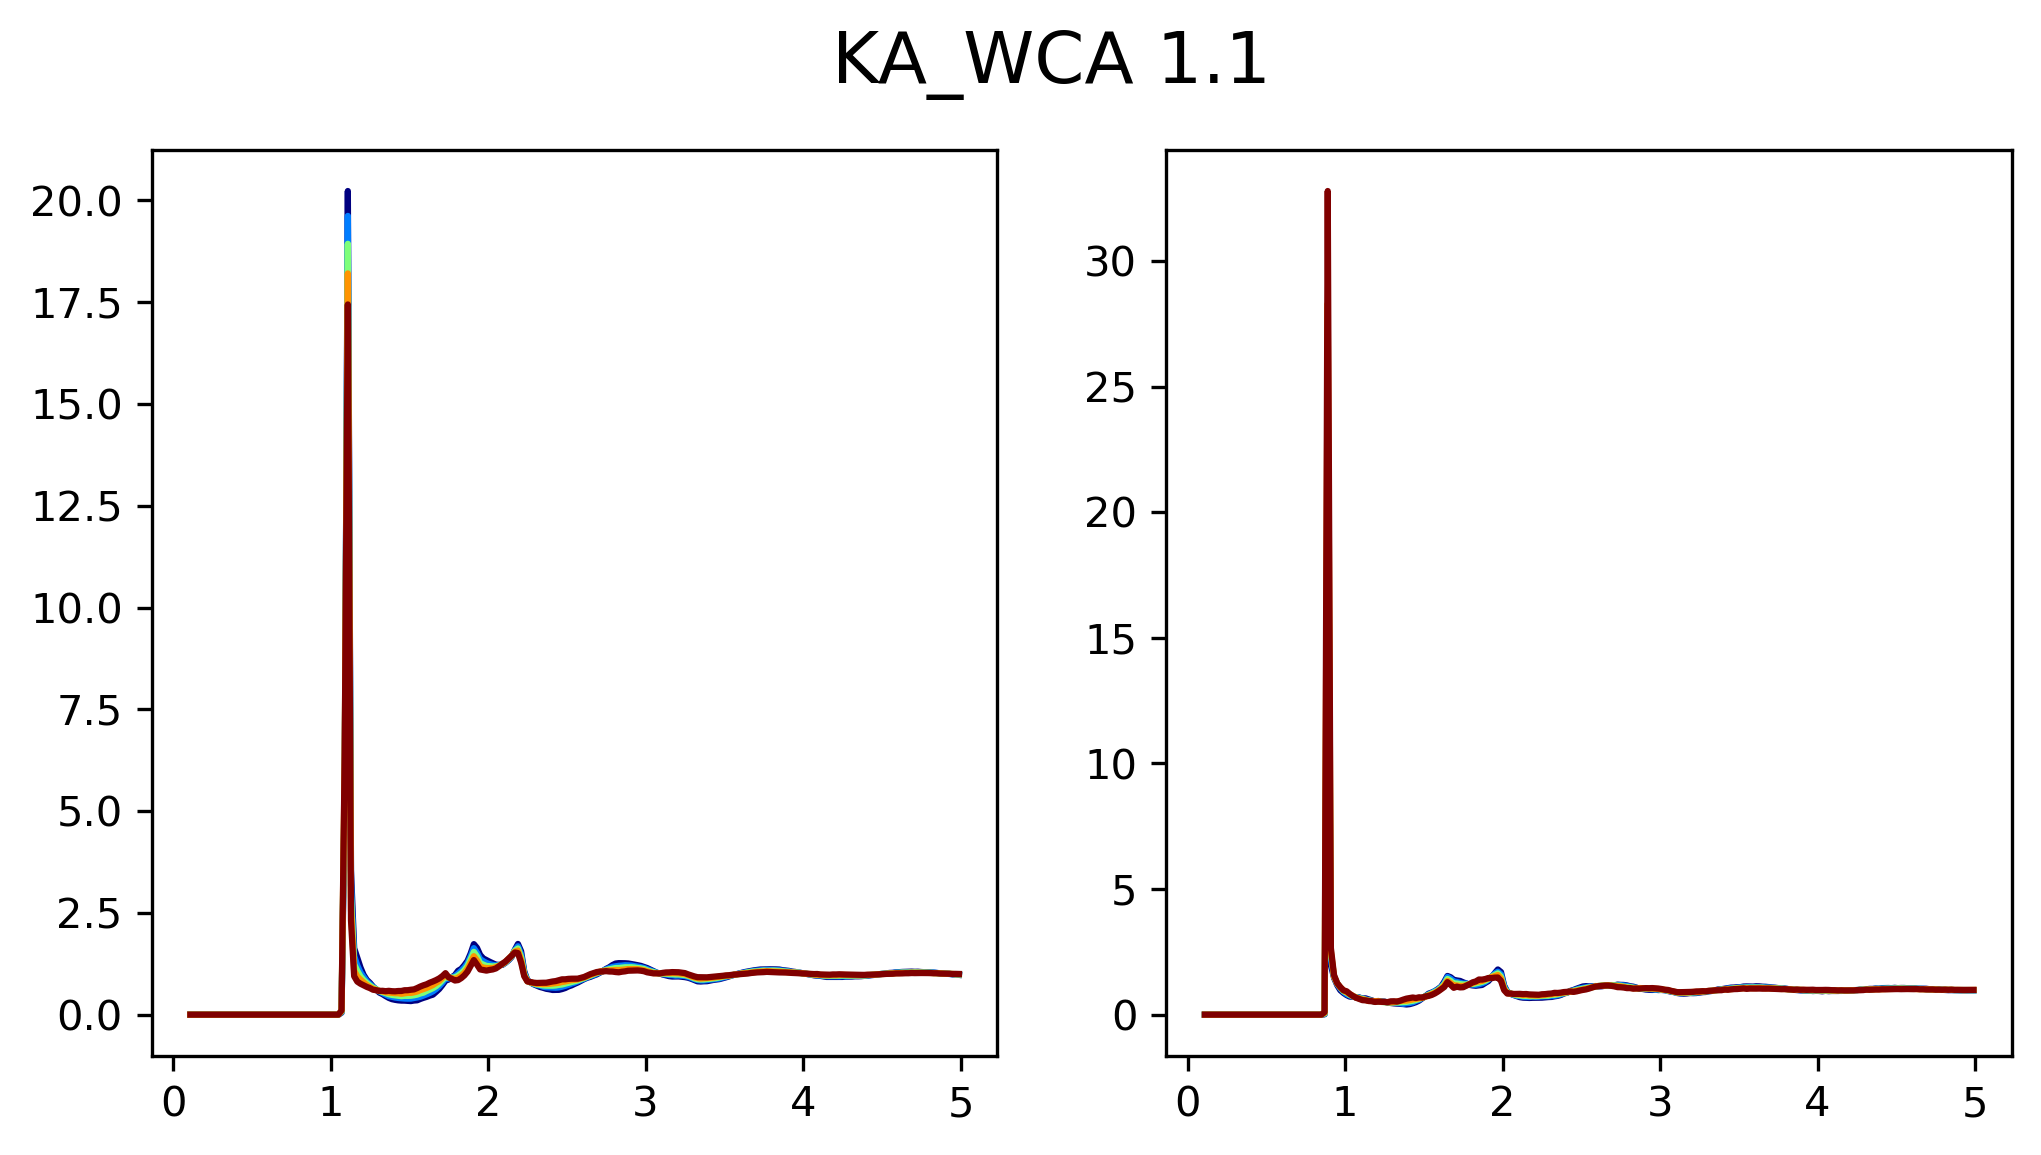

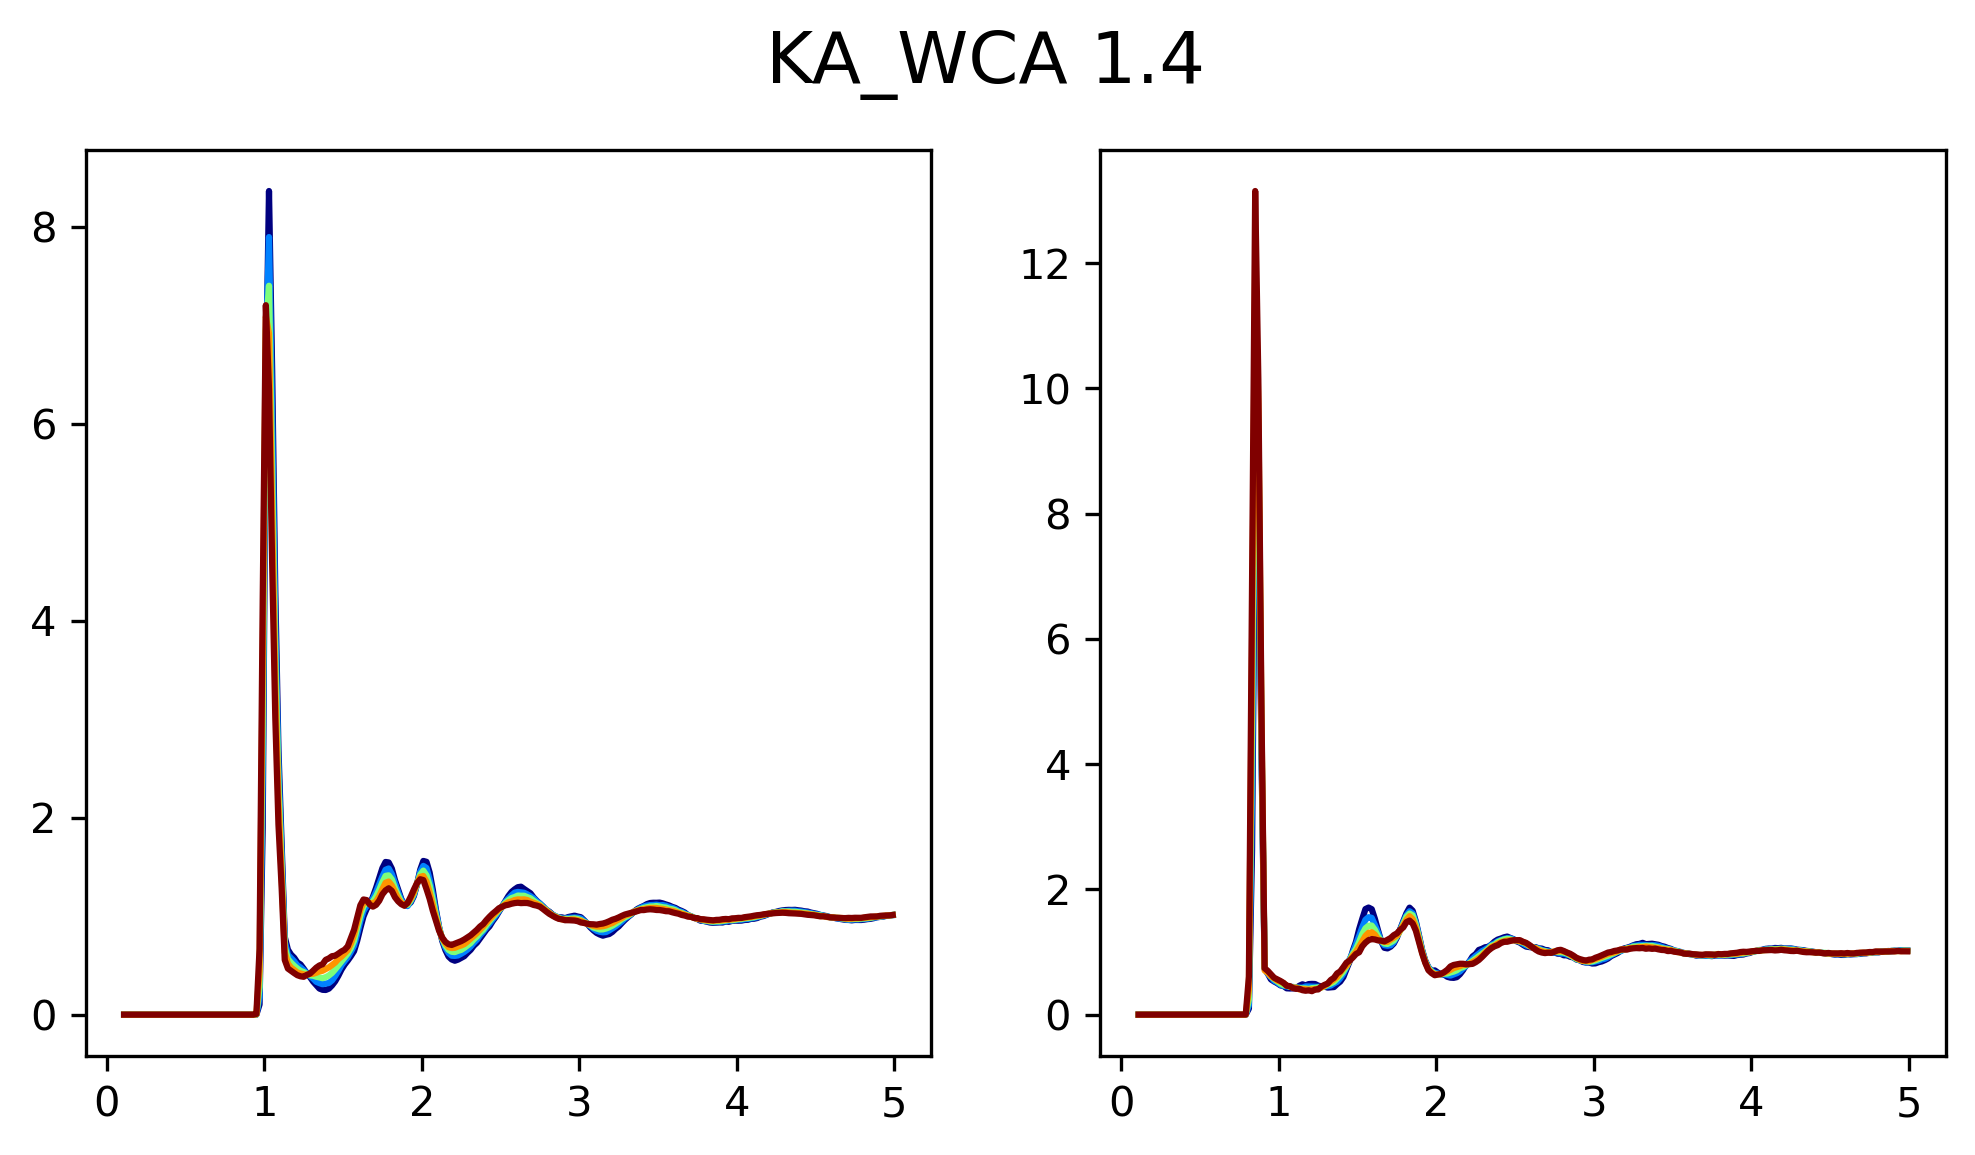

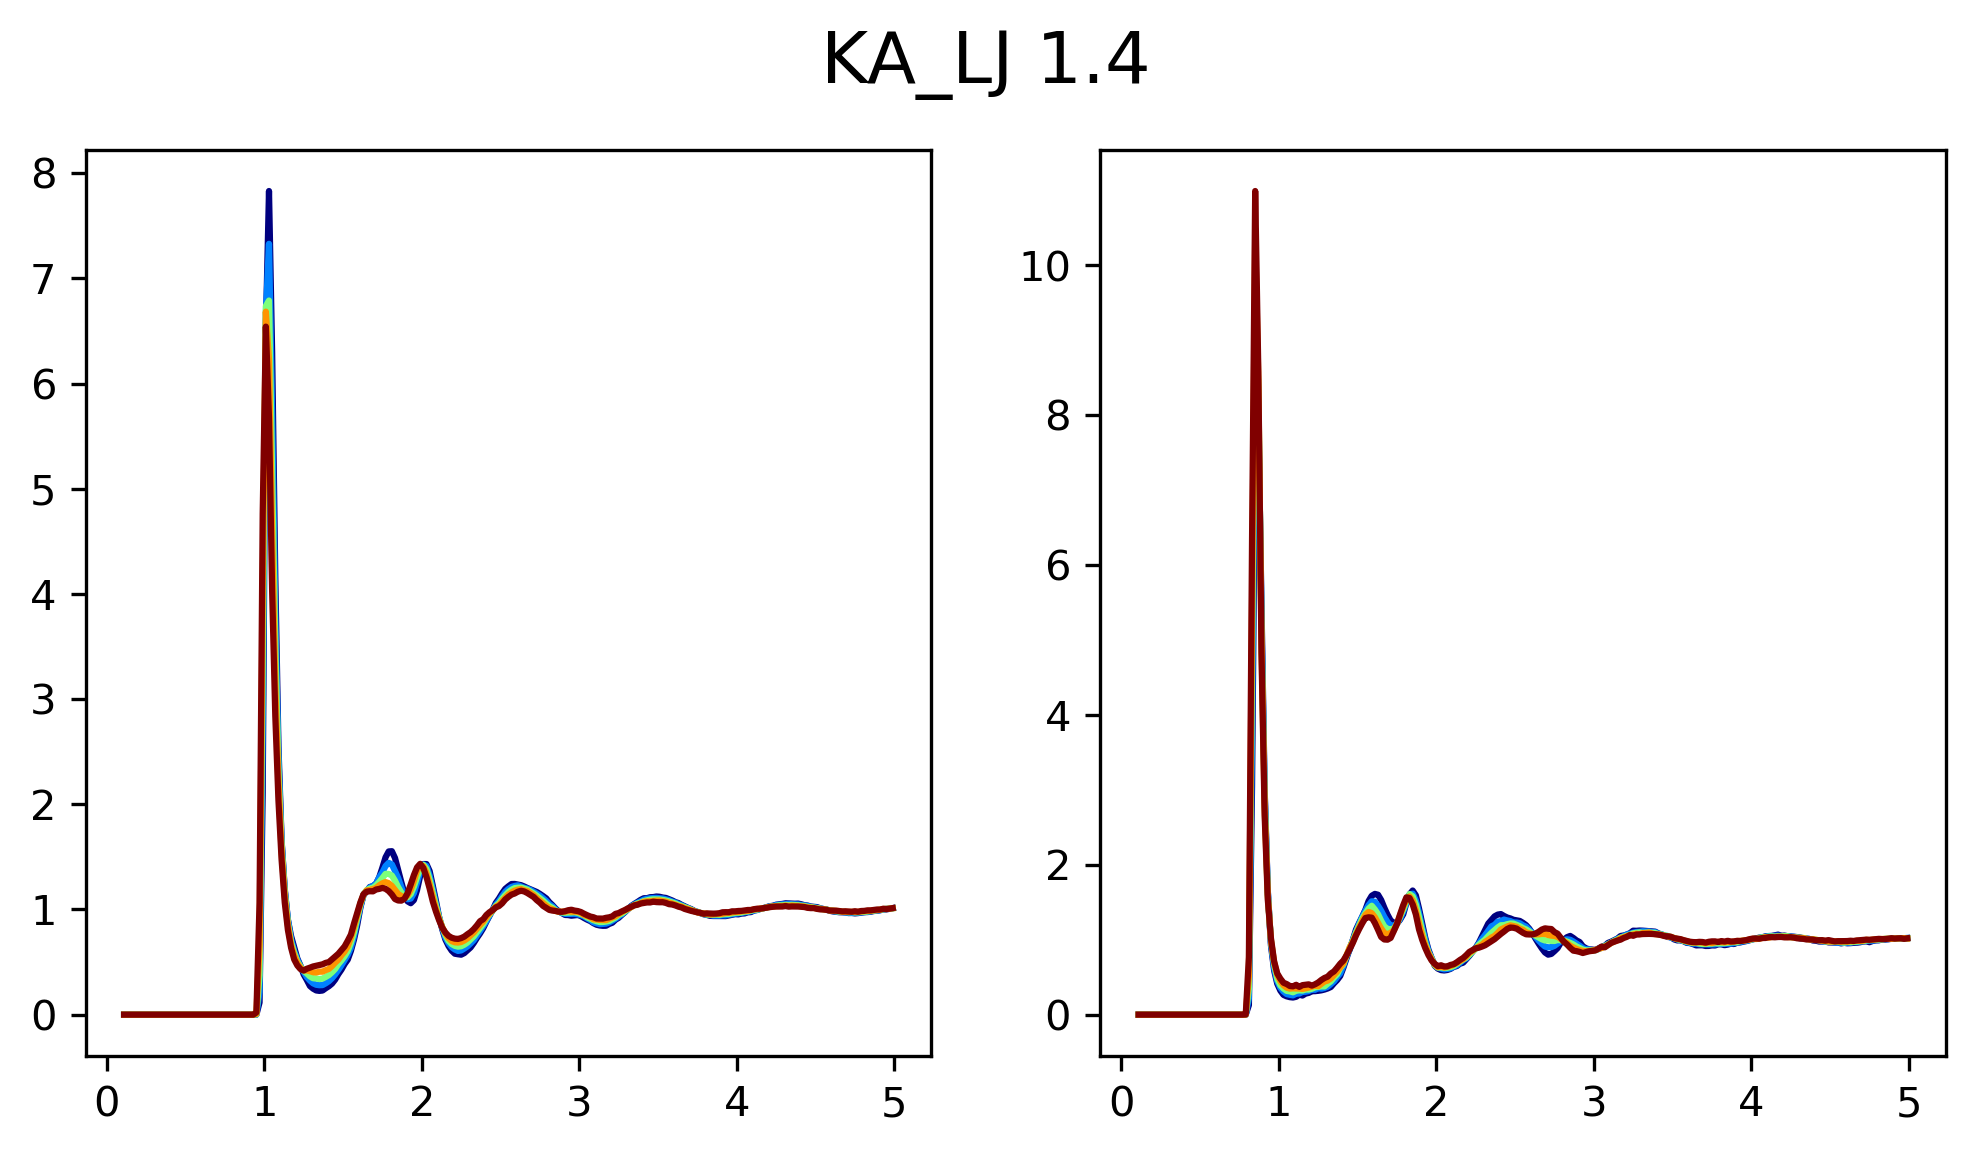

In [57]:

markers = {"KA_WCA": "o", "KA_LJ": "s"}

for job in project:
    if not job.isfile(f"analysis/rdfs-bin-softness-fire.pickle"):
        continue
    file = job.fn(f"analysis/rdfs-bin-softness-fire.pickle")

    fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)

    fig.suptitle(f"{job.sp['pot']} {job.sp['rho']}", size="xx-large")

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    in_cuts = data["data"][0]["cuts"]
    cmap = cm.jet
    norm = colors.Normalize(np.min(in_cuts), np.max(in_cuts))
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = job.sp["rho"]
    for j in range(len(itemps))[-1:]:
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            axs[0].plot(r, g_a, color=cmap(norm(data["cuts"][i])))
            axs[1].plot(r, g_b, color=cmap(norm(data["cuts"][i])))
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            tmp_temps = np.array(itemps)
            tmp_val = np.array(rearrang)
            mask = ~np.isnan(val)
            tmp_temps = tmp_temps[mask]
            tmp_val = tmp_val[mask]
            p = np.polyfit(tmp_temps, np.log(tmp_val), 1)

            fits.append(p)

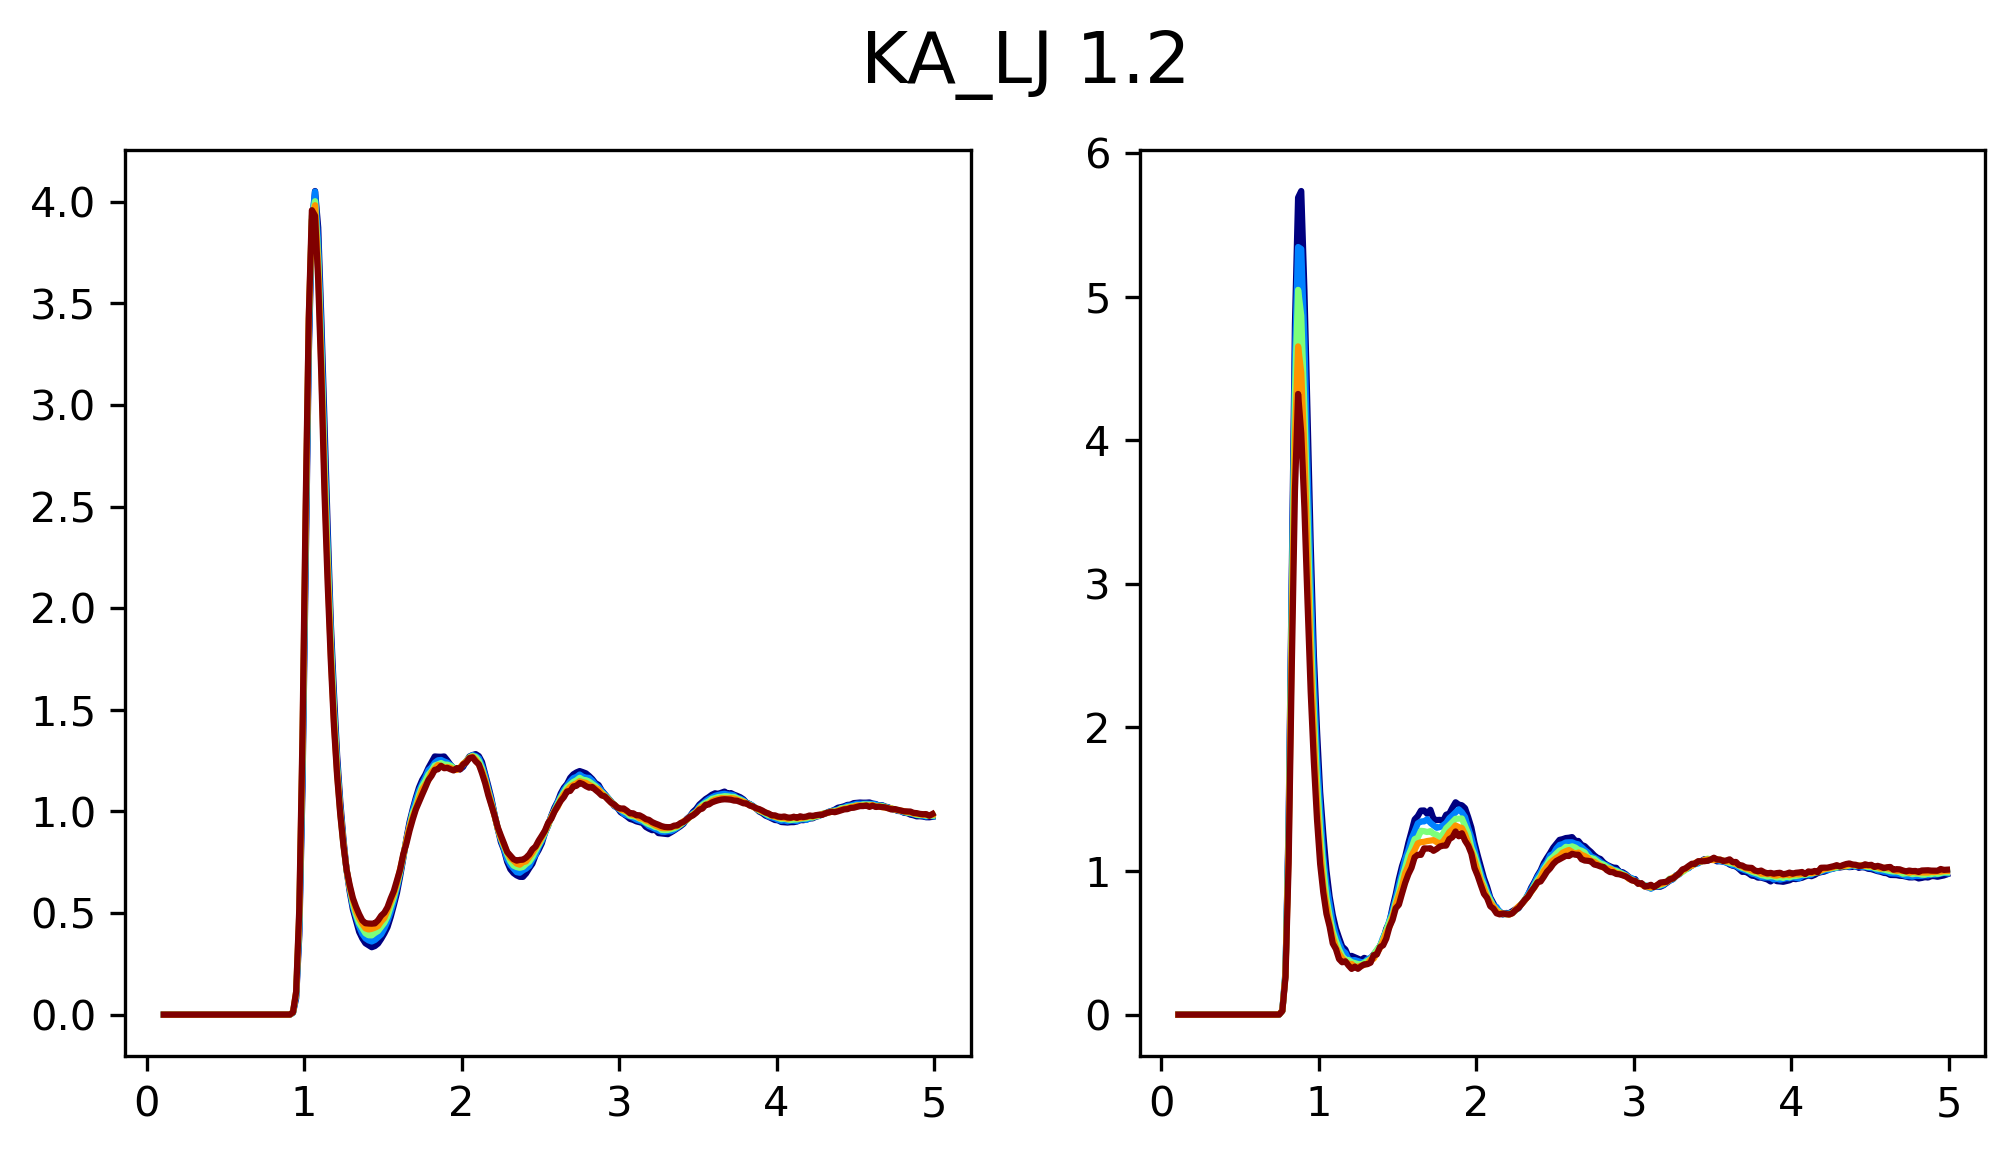

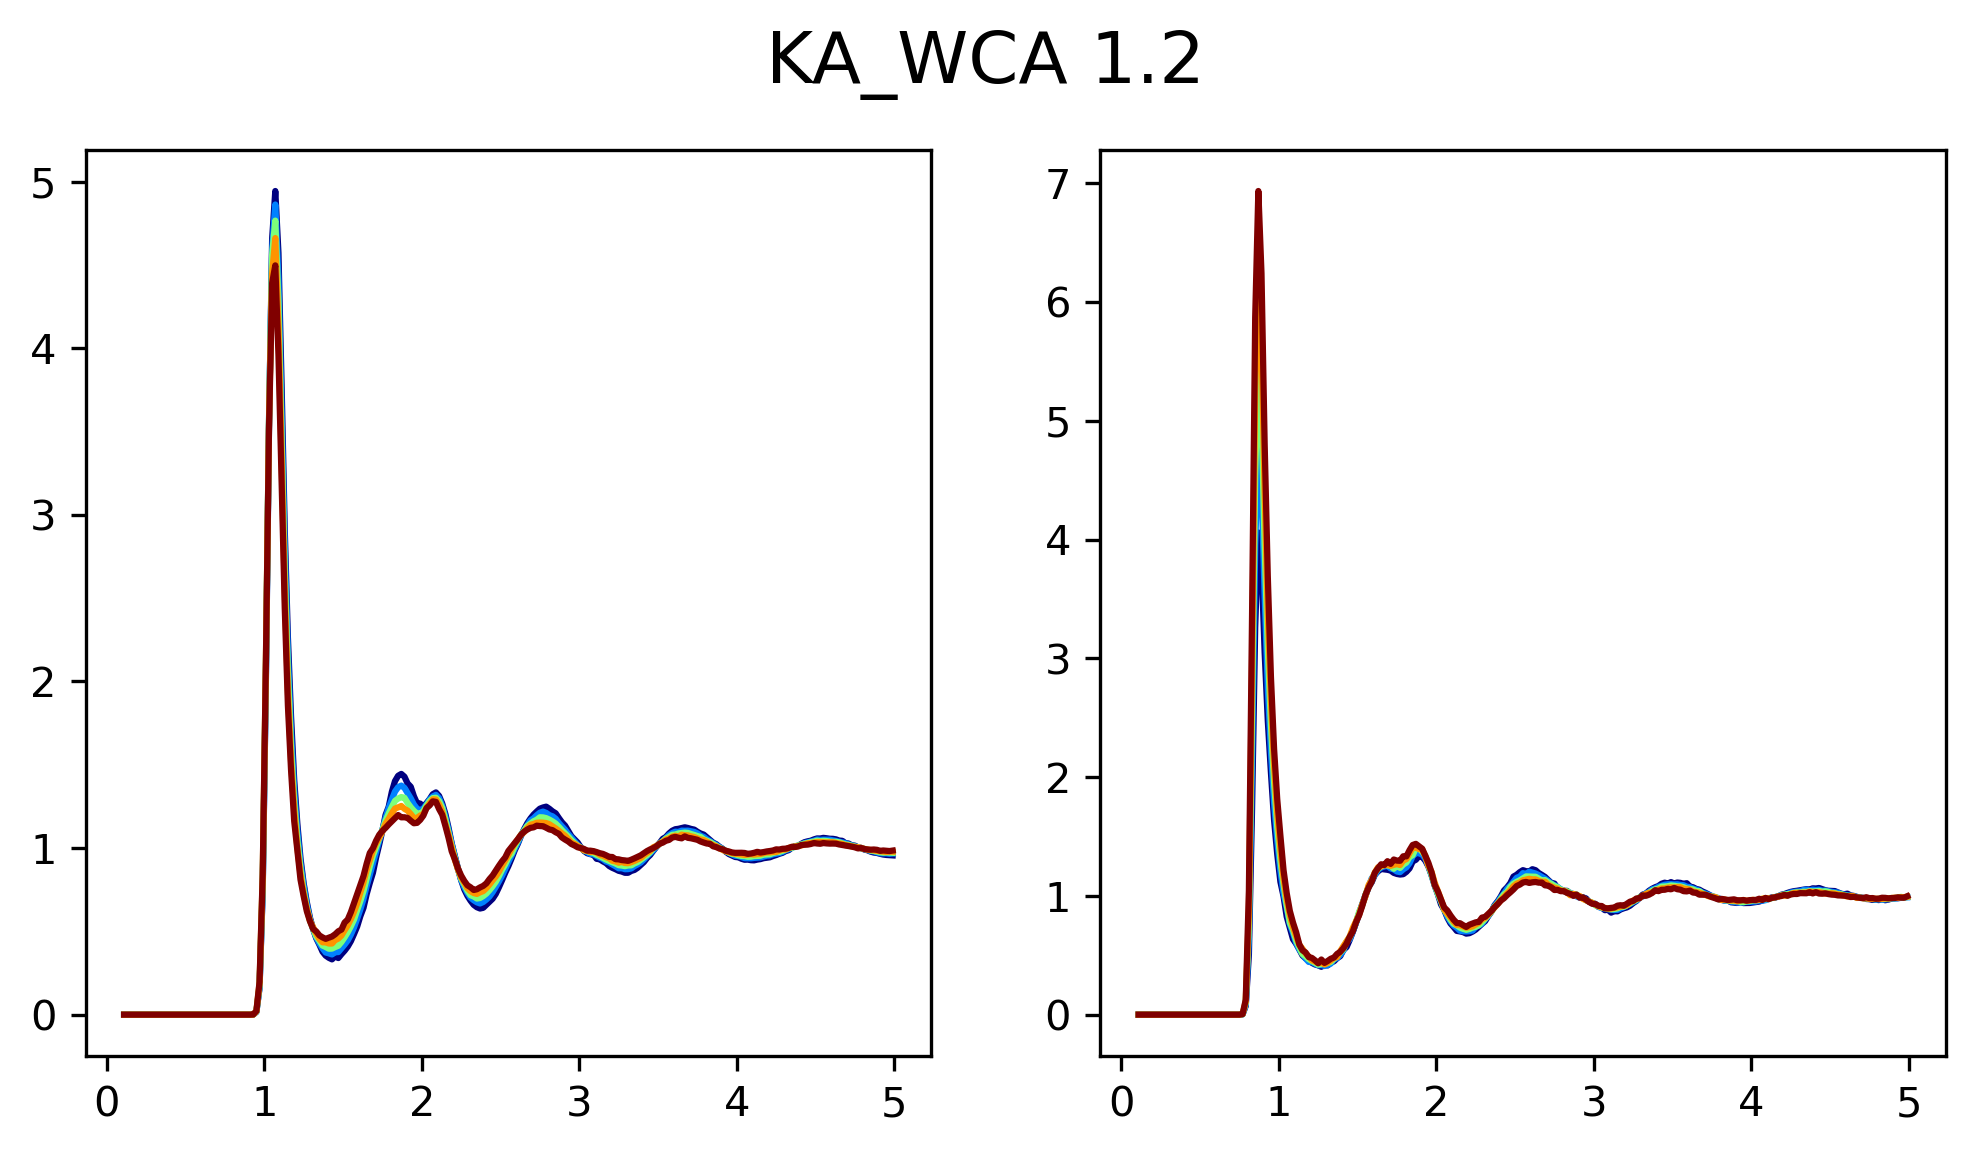

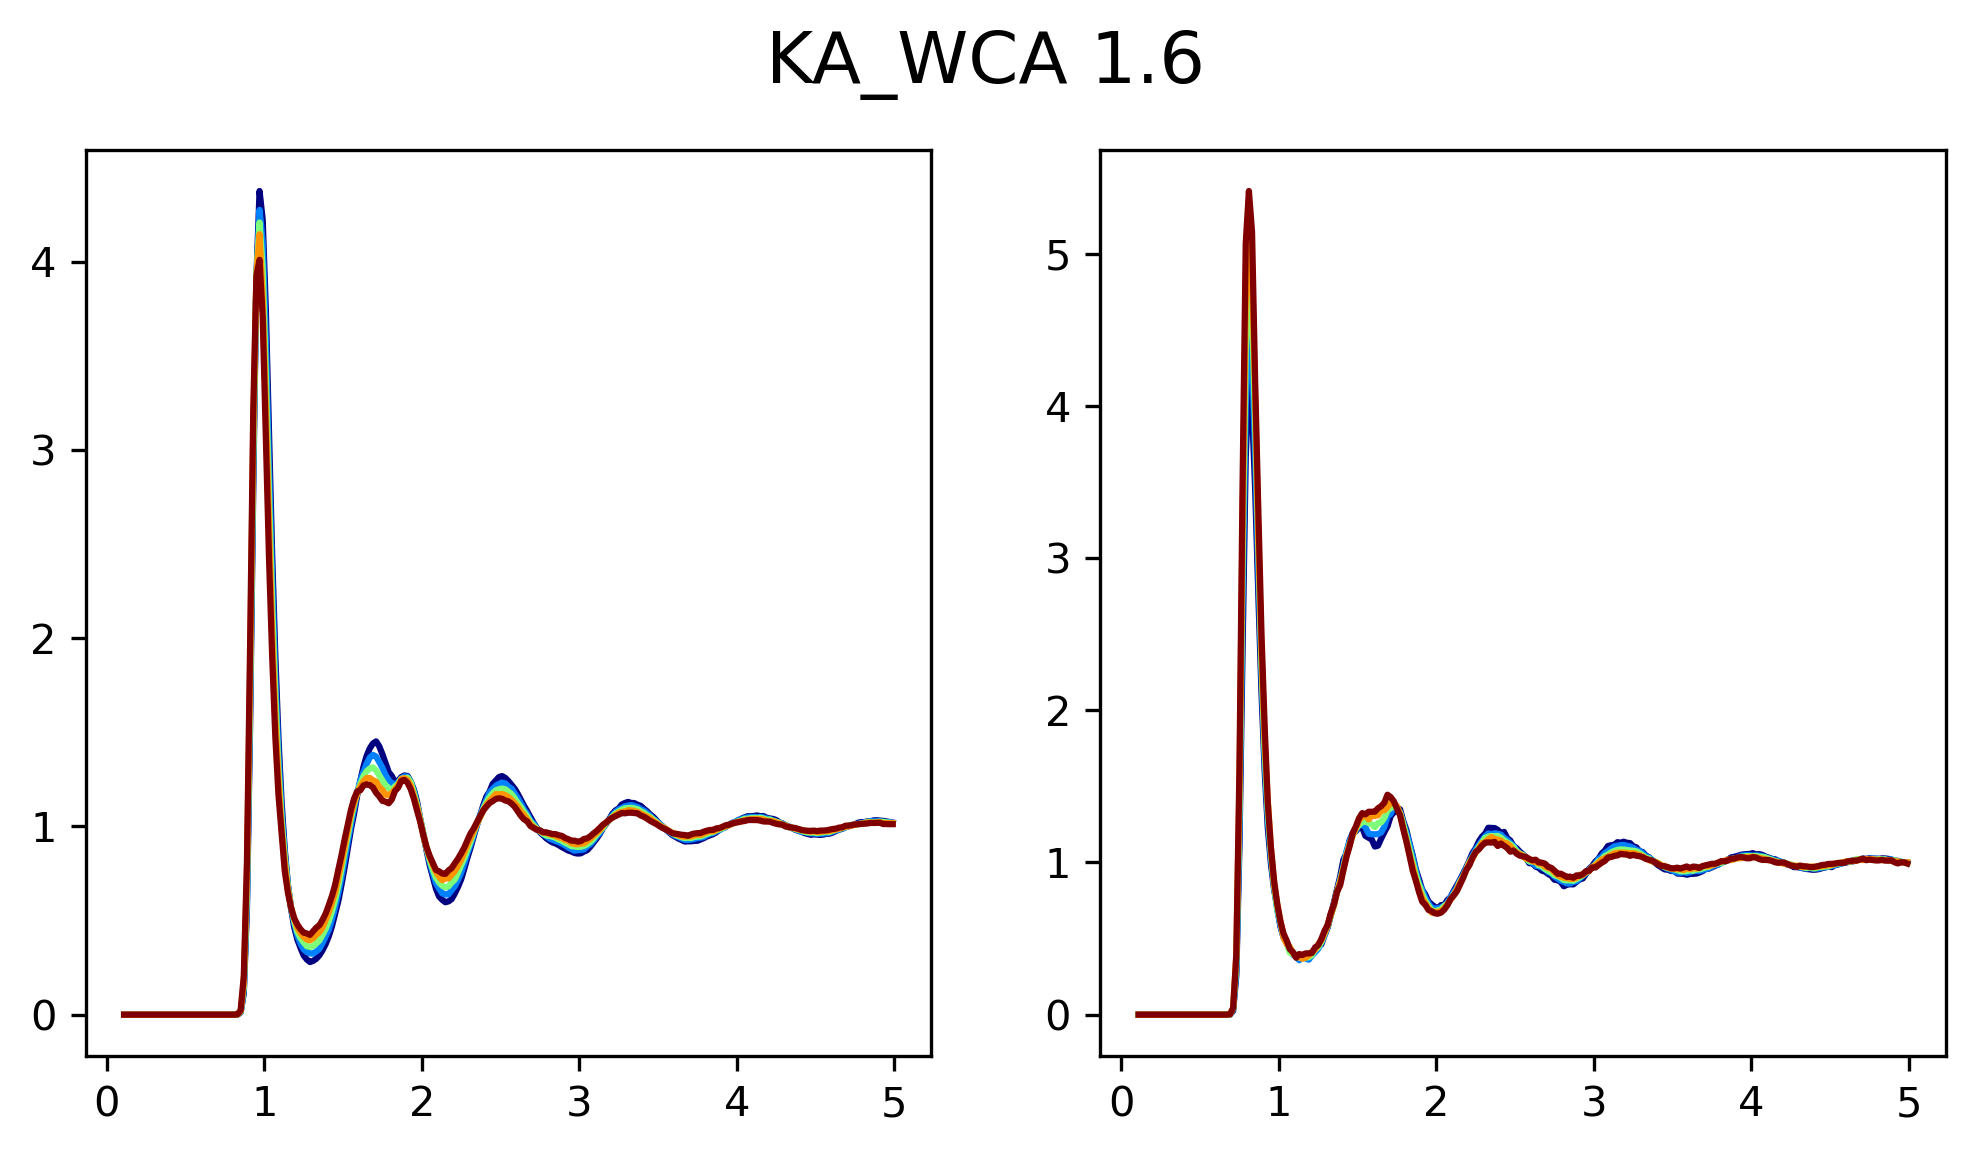

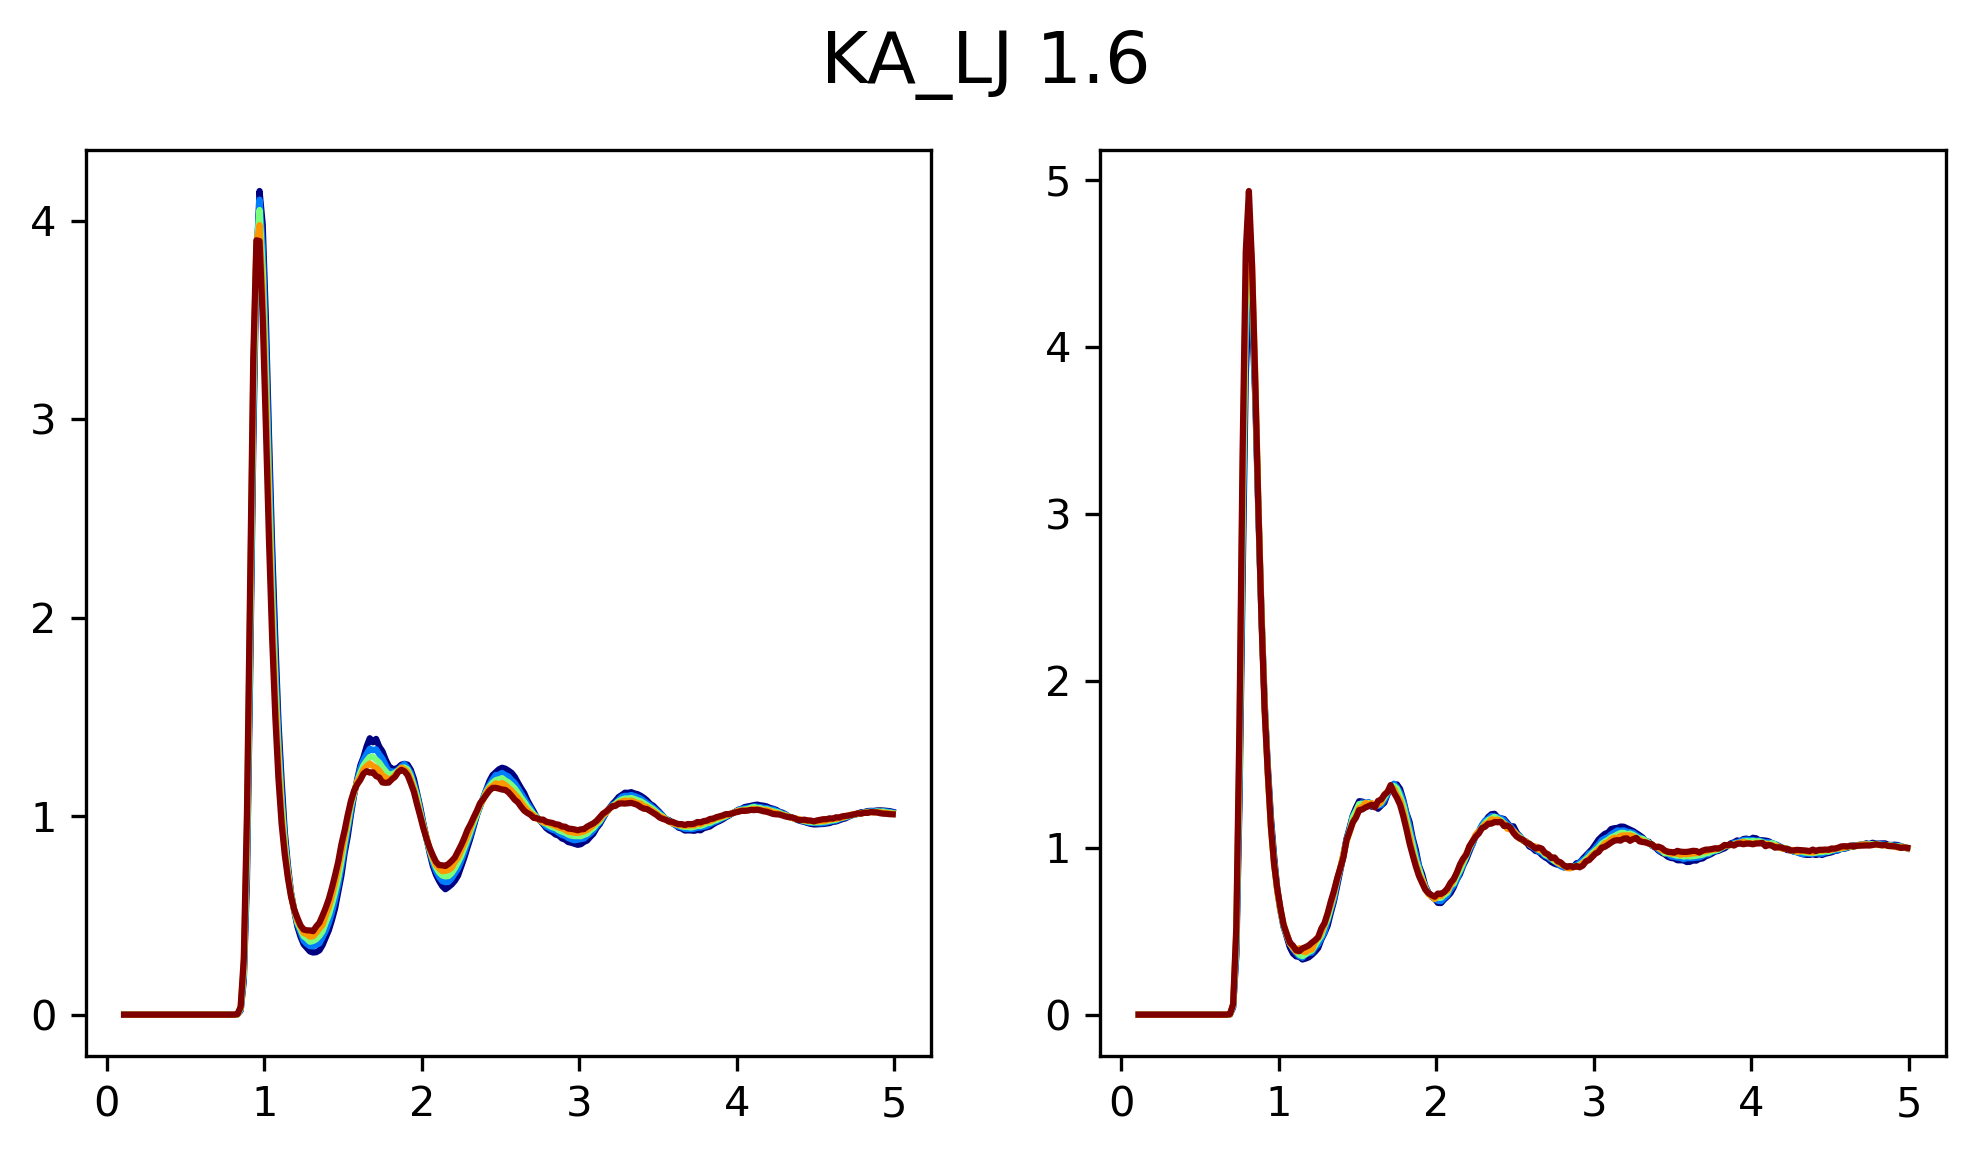

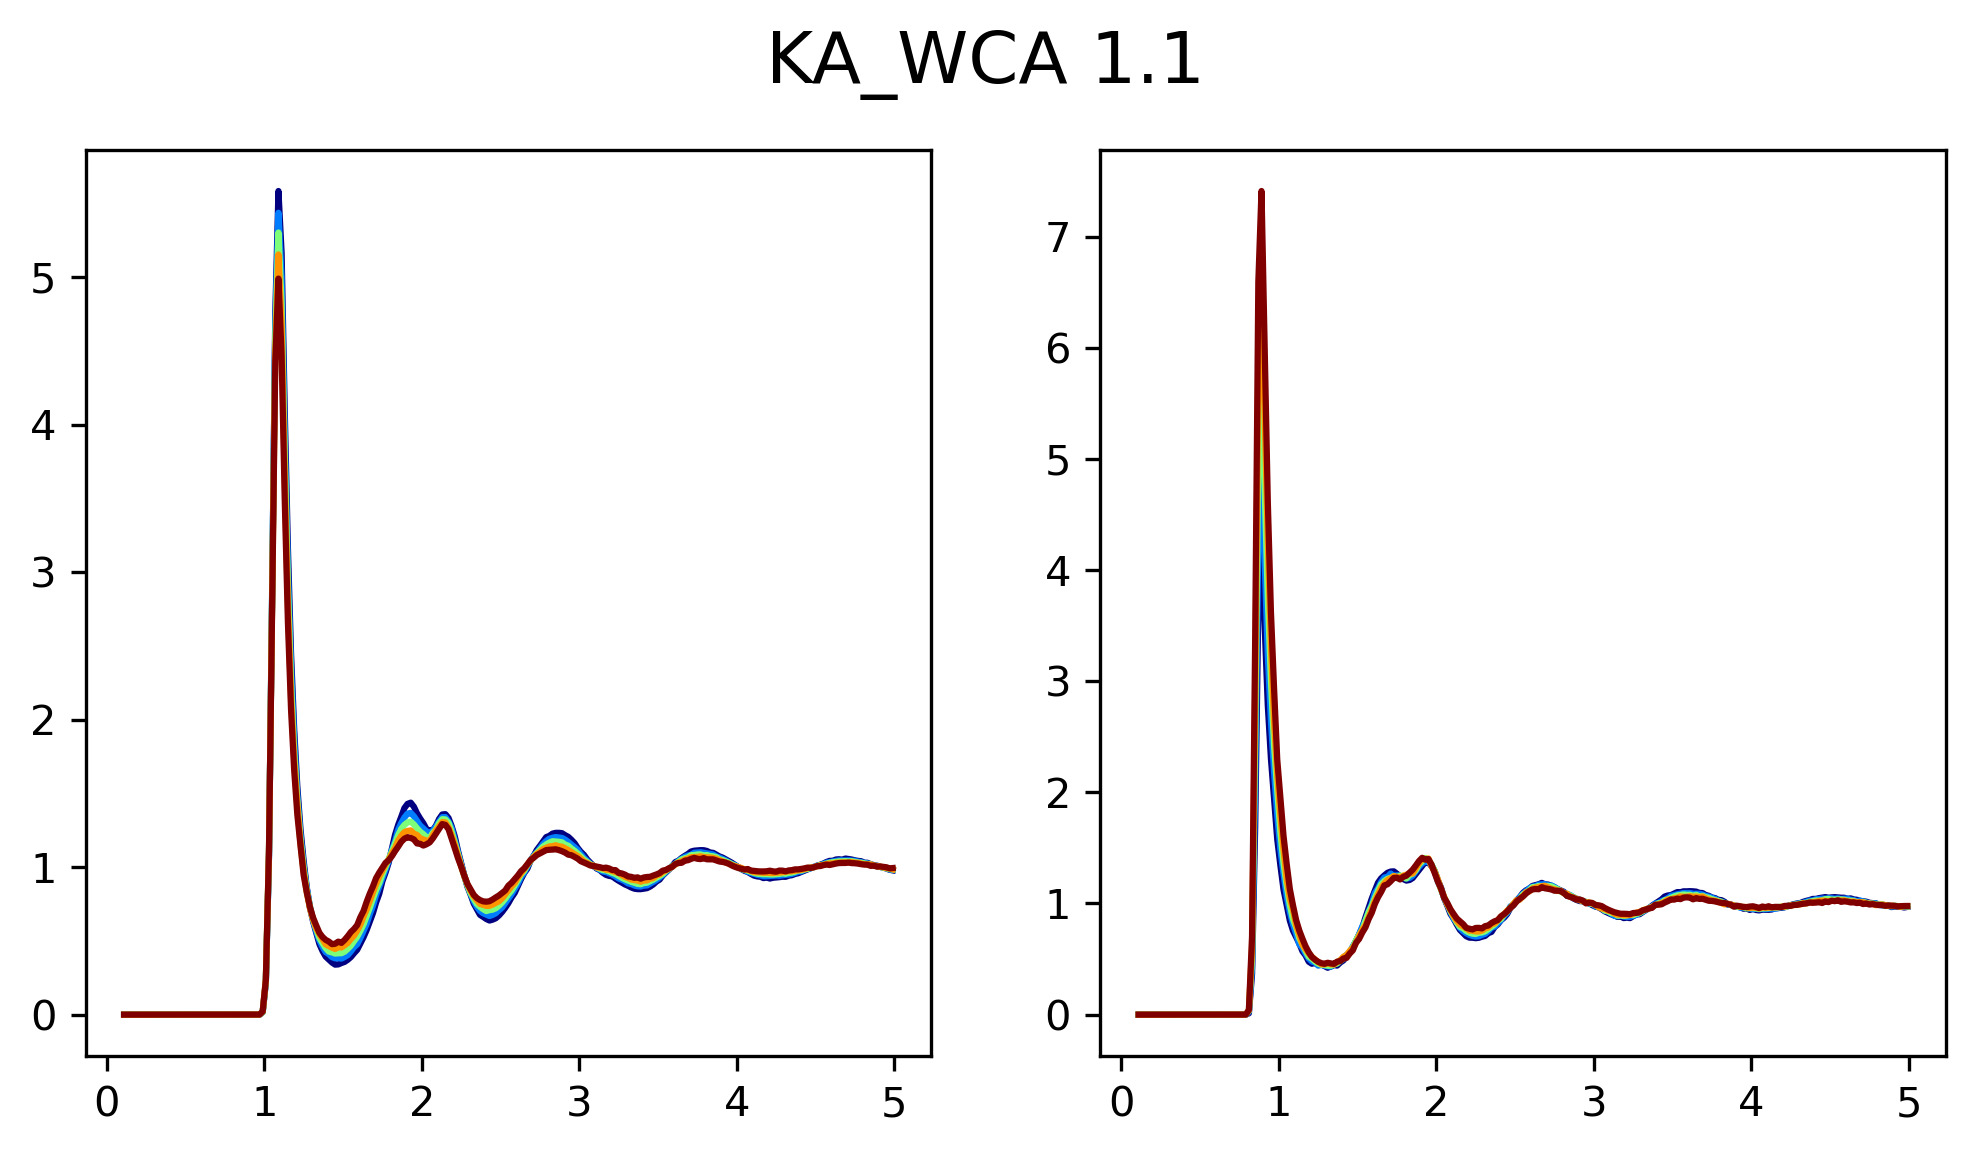

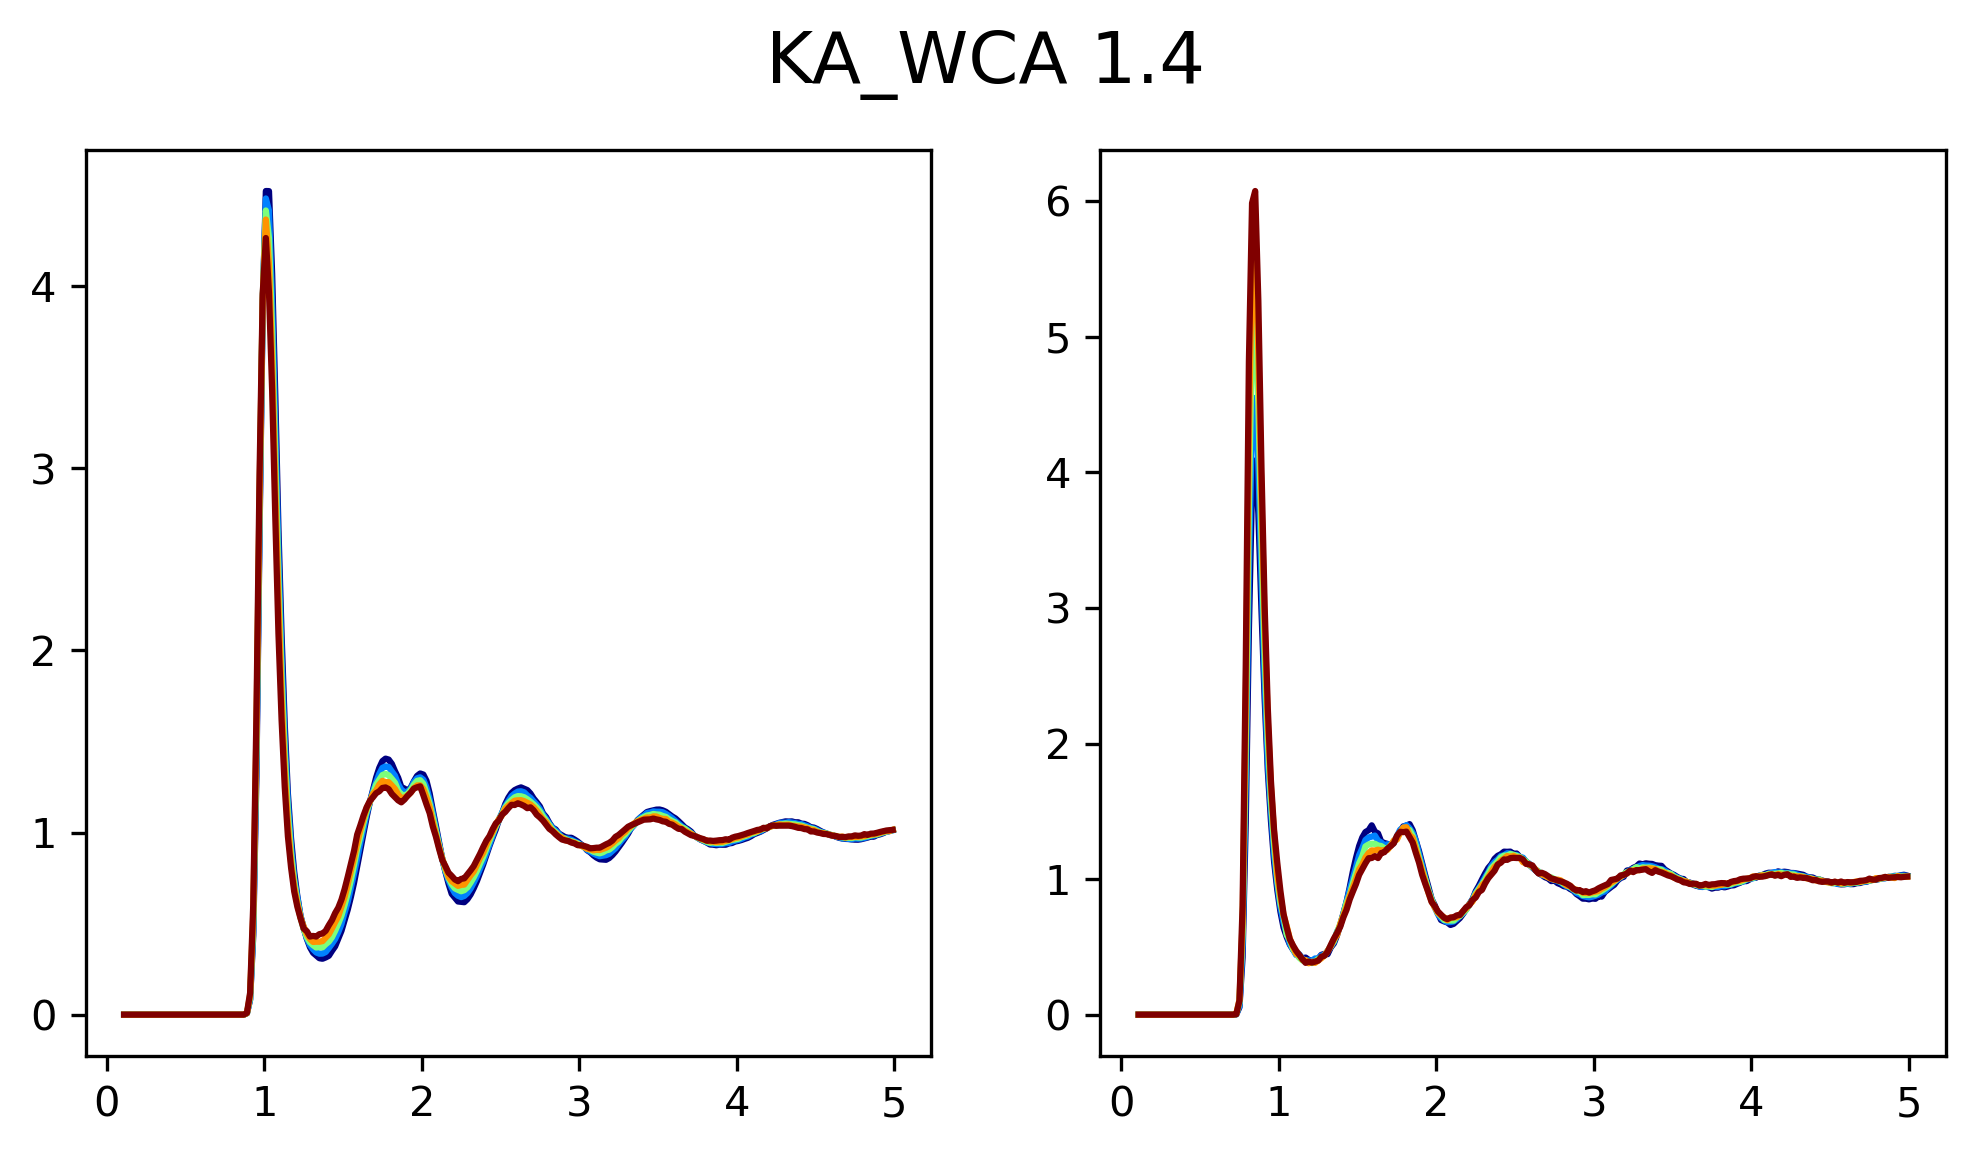

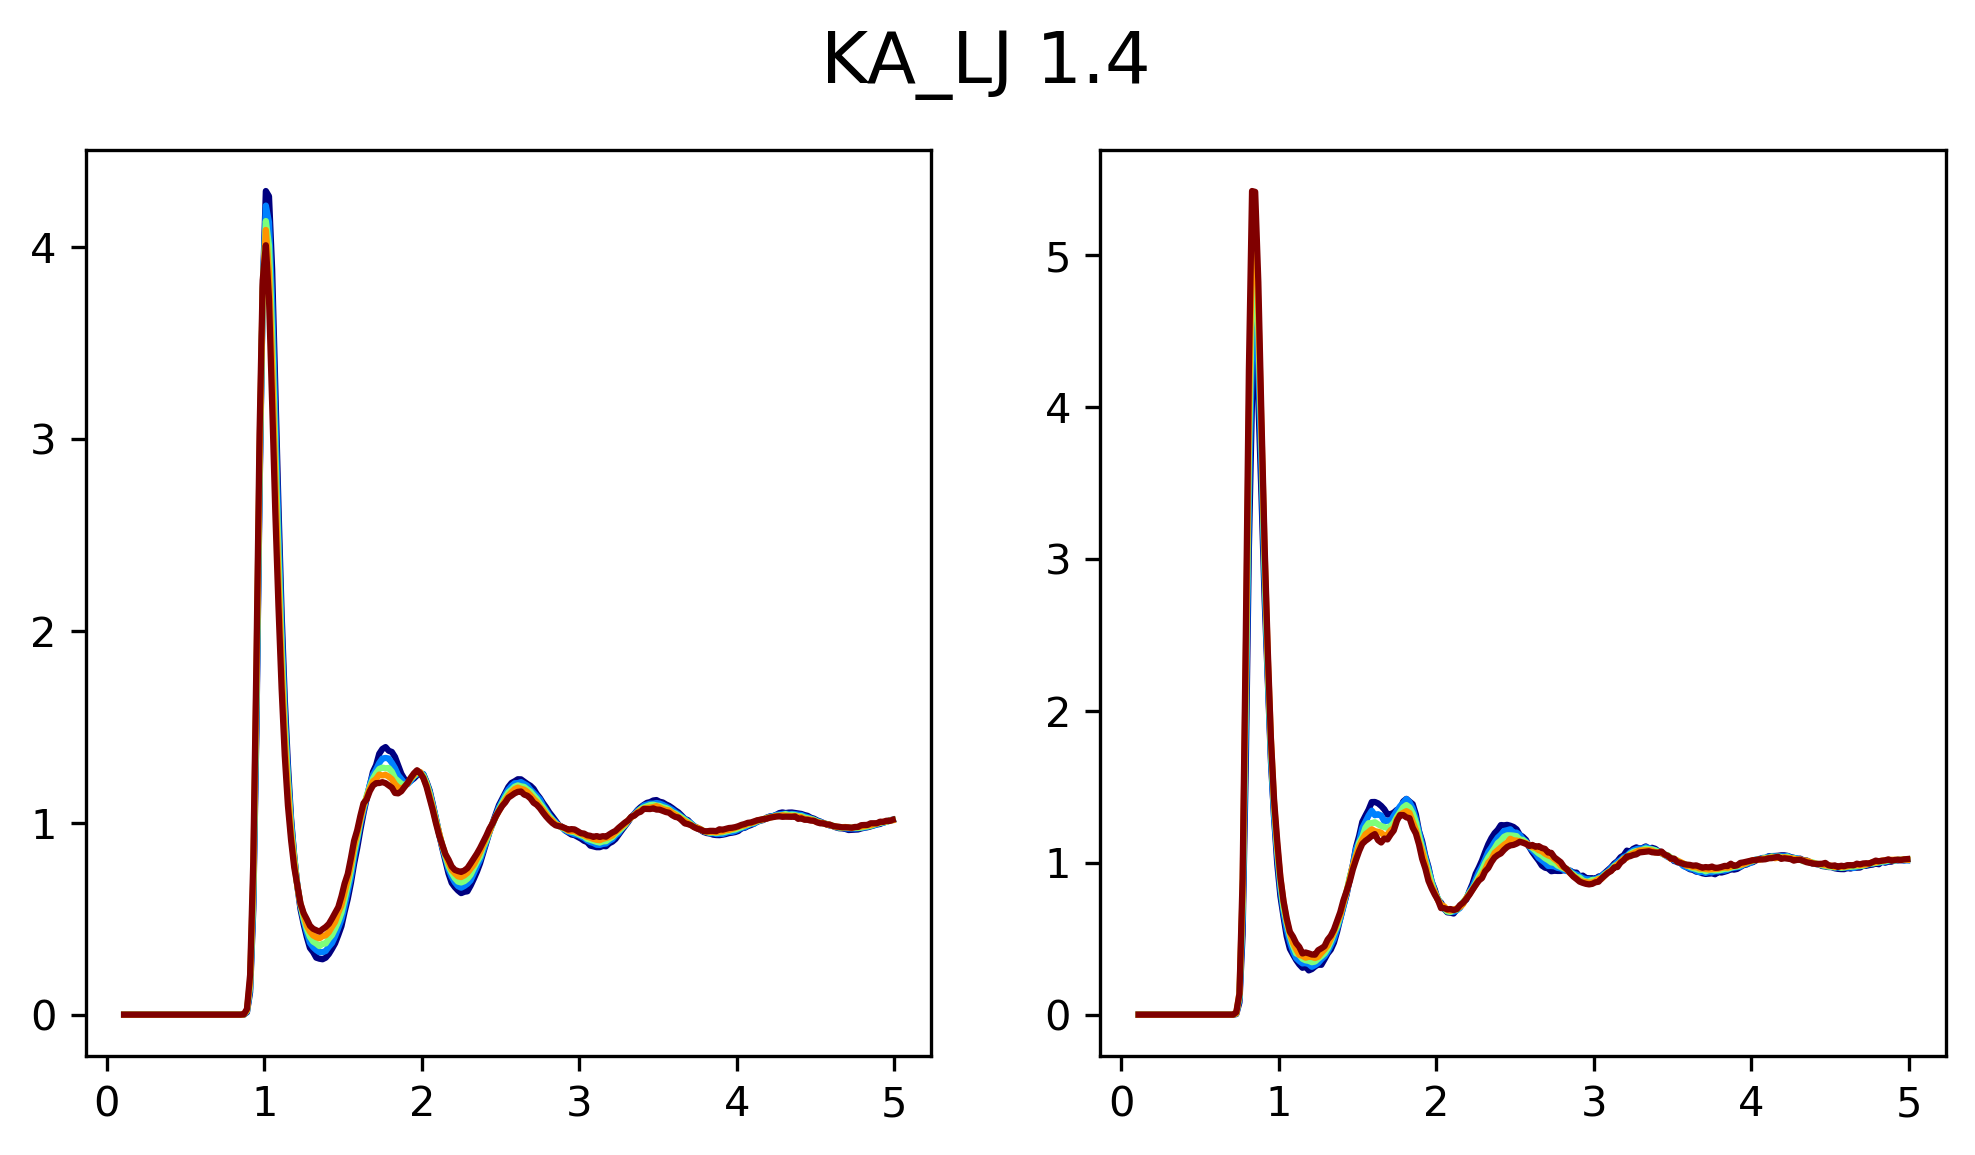

In [59]:

markers = {"KA_WCA": "o", "KA_LJ": "s"}

for job in project:
    if not job.isfile(f"analysis/rdfs-bin-softness.pickle"):
        continue
    file = job.fn(f"analysis/rdfs-bin-softness.pickle")

    fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)

    fig.suptitle(f"{job.sp['pot']} {job.sp['rho']}", size="xx-large")

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    in_cuts = data["data"][0]["cuts"]
    cmap = cm.jet
    norm = colors.Normalize(np.min(in_cuts), np.max(in_cuts))
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = job.sp["rho"]
    for j in range(len(itemps))[:1]:
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            axs[0].plot(r, g_a, color=cmap(norm(data["cuts"][i])))
            axs[1].plot(r, g_b, color=cmap(norm(data["cuts"][i])))
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            tmp_temps = np.array(itemps)
            tmp_val = np.array(rearrang)
            mask = ~np.isnan(val)
            tmp_temps = tmp_temps[mask]
            tmp_val = tmp_val[mask]
            p = np.polyfit(tmp_temps, np.log(tmp_val), 1)

            fits.append(p)

d395695118c2c7c531f3aeee70f4b196
{'N': 32768, 'replica': 0, 'rho': 1.2, 'pot': 'KA_WCA'}
848bac84d23c56bb5e7cbef2d87d5b61
{'N': 32768, 'replica': 0, 'rho': 1.4, 'pot': 'KA_LJ'}
2235dfb89ffc998c28e26ddb0aa5889f
{'N': 32768, 'replica': 0, 'rho': 1.6, 'pot': 'KA_WCA'}
6f9e365130a0f6be570fcc9758c9875d
{'N': 32768, 'replica': 0, 'rho': 1.6, 'pot': 'KA_LJ'}
3b18c98a8738fa8b1b54954b5002010b
{'N': 32768, 'replica': 0, 'rho': 1.4, 'pot': 'KA_WCA'}
a03bdc2a5be70a1e699a3f825fb8877b
{'N': 32768, 'replica': 0, 'rho': 1.2, 'pot': 'KA_LJ'}
37ae73cd14c8398e29fed6204f43a155
{'N': 32768, 'replica': 0, 'rho': 1.1, 'pot': 'KA_WCA'}


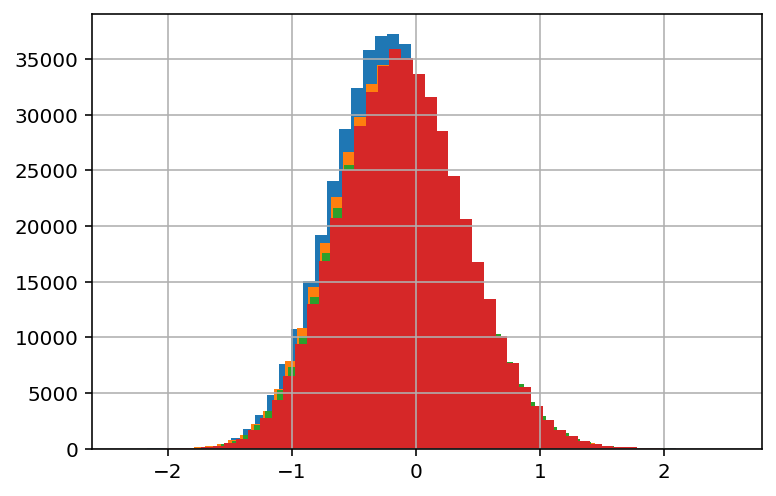

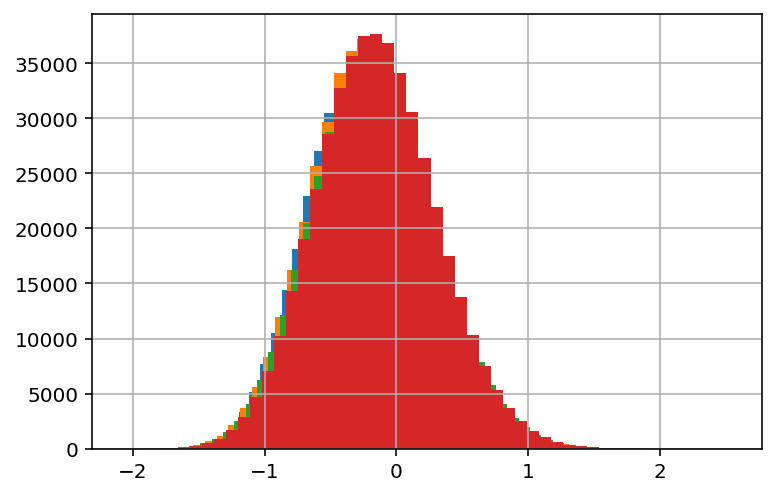

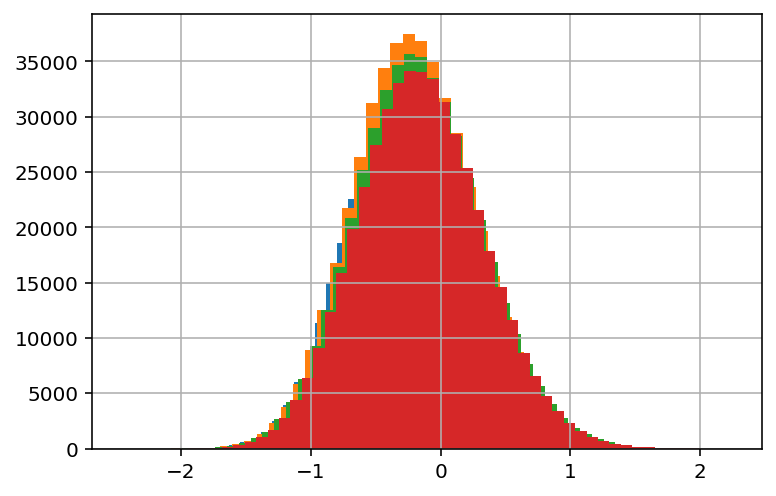

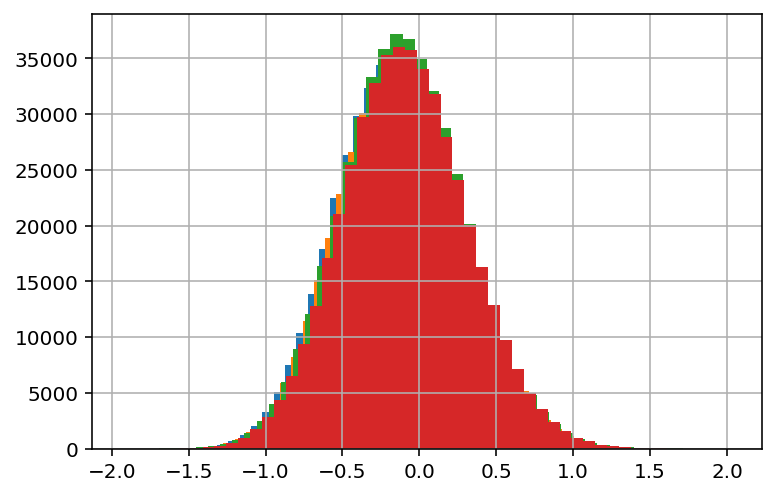

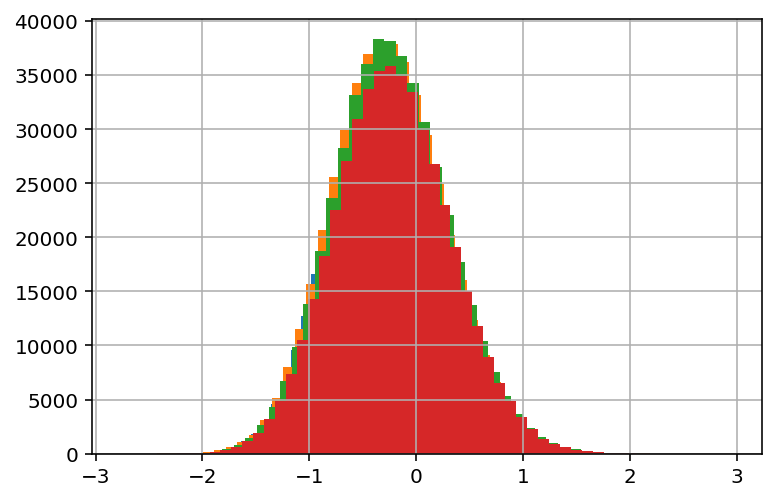

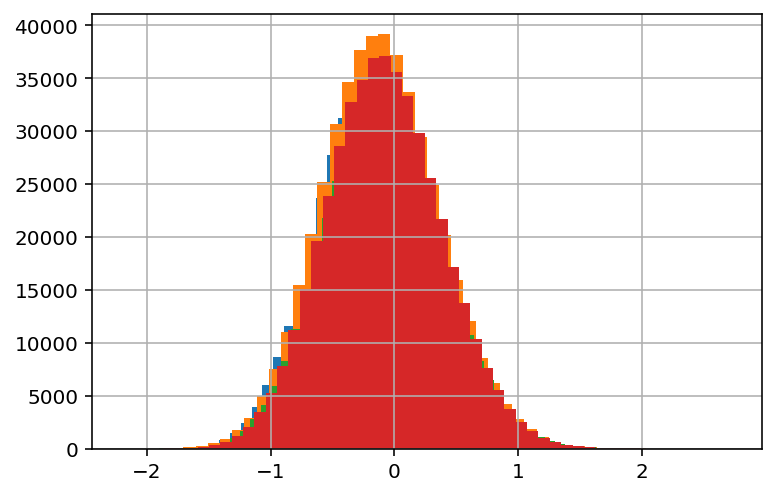

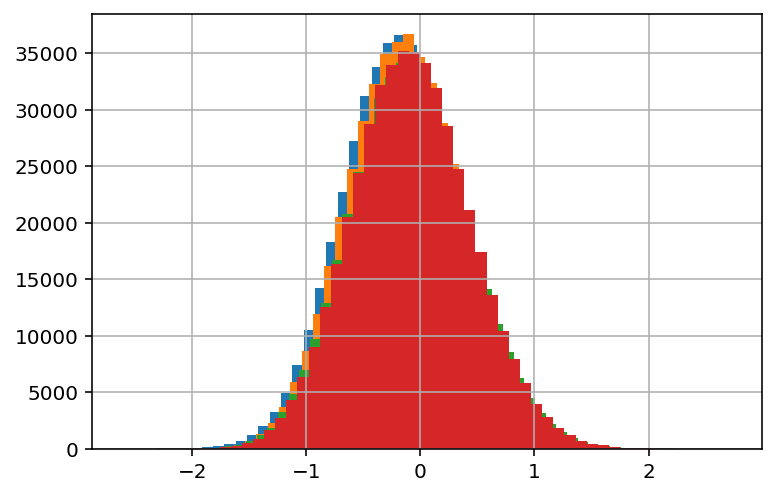

In [36]:
for job in project.find_jobs(None, {"softness_trained": True}):
    dfs = sorted(glob.glob(job.fn("analysis/analysis-sfs_*.parquet")))
    print(job)
    print(job.sp)

    plt.figure()

    cats = None
    
    for idx, df_name in enumerate(dfs):
        df = pd.read_parquet(df_name)
        df = df[df["type"] == 0]
        temp = float(utils.extract_between(df_name, "analysis-sfs_temp-", ".parquet"))
        
        df["softness"].hist(bins=50)

    # break

    # plt.yscale('log')
    # plt.xlabel("1/T")
    # plt.ylabel("P_R")

In [35]:
df["softness"]

0        -0.568658
1        -0.709367
2         0.636777
3         0.271786
6         0.608923
            ...   
589817    0.113571
589818    0.377945
589820    0.051658
589821    0.919734
589823   -0.350752
Name: softness, Length: 471870, dtype: float64